In [2]:
import numpy as np
import jax.numpy as jnp
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import einops as ein
from patsy import dmatrix
from pandas.tseries.holiday import USFederalHolidayCalendar
from bayesinsight.lib.adstock import delayed_adstock

In [3]:
N_YEARS = 4
N_WEEKS_PER_YEAR = 52
date = pd.date_range(start="1/1/2020", periods=N_WEEKS_PER_YEAR*N_YEARS, freq="W-MON")
calendar = USFederalHolidayCalendar()
holidays = pd.DataFrame(index=pd.date_range(start=date.min(), end=date.max(), freq='D'))
holidays = holidays.join(
  pd.get_dummies(pd.DataFrame(
    columns=['Holiday'], 
    data=calendar.holidays(
      start=date.min(),
      end=date.max(), 
      return_name=True)
      ), drop_first=False).astype(int)).fillna(0).resample("W-MON").sum()
campaigns = ["A", "B", "C"]
products = ["X", "Y"]
geographies = ["NY", "CA", "TX", "ME"]
olv_outlets = ["YouTube", "Prime"]
olv_creatives = ["15", "30"]
social_outlets = ["Facebook", "Instagram", "Snapchat"]
social_creatives = ["Image", "Video"]
display_outlets = ["Yahoo", "DVM"]
display_creatives = ["Desktop-Large", "Mobile", "Desktop-Small"]
search_outlets = ["Bing", "Google"]
search_creatives = ["Generic", "Branded"]
audio_outlets = ["Spotify", "Pandora"]
audio_creatives = ["Streamming", "Podcast"]
product_importance = {"X": 1.0, "Y": 1.5}
geography_size = {"NY": 1.0, "CA": 1.5, "TX": 1.75, "ME": 0.75}
campaign_size = {"A": 1.0, "B": 1.5, "C": 2.0}
outlet_size = {
  "YouTube": 1.0, "Prime": 1.5, 
  "Facebook": 1.0, "Instagram": 1.5, "Snapchat": 0.5, 
  "Yahoo": 3, "DVM": 1,
  "Google": 1.5, "Bing": 0.2,
  "Spotify": 1.5, "Pandora": 0.5
  }
creative_size = {
  "15": 1.0, "30": 1.5, 
  "Image": 1.0, "Video": 1.5, 
  "Desktop-Large": 1.0, "Mobile": 1.5, "Desktop-Small": 0.5, 
  "Generic": 1.0, "Branded": 1.5,
  "Streamming": 1.0, "Podcast": 0.5
  }
OLV_OPTIONS = {
  "outlets": olv_outlets,
  "creatives": olv_creatives
}
SOCIAL_OPTIONS = {
  "outlets": social_outlets,
  "creatives": social_creatives
}
DISPLAY_OPTIONS = {
  "outlets": display_outlets,
  "creatives": display_creatives
}
SEARCH_OPTIONS = {
  "outlets": search_outlets,
  "creatives": search_creatives
}
AUDIO_OPTIONS = {
  "outlets": audio_outlets,
  "creatives": audio_creatives
}
CHANNELS = {
  "OLV": OLV_OPTIONS,
  "SOCIAL": SOCIAL_OPTIONS,
  "DISPLAY": DISPLAY_OPTIONS,
  "SEARCH": SEARCH_OPTIONS,
  "AUDIO": AUDIO_OPTIONS
}
CHANNELS_SIZE = {
  "OLV": 0.8,
  "SOCIAL": 1.5,
  "DISPLAY": 2.0,
  "AUDIO": 1.1
}

In [4]:
factorial = lambda x: 1 if x == 0 else x * factorial(x - 1)


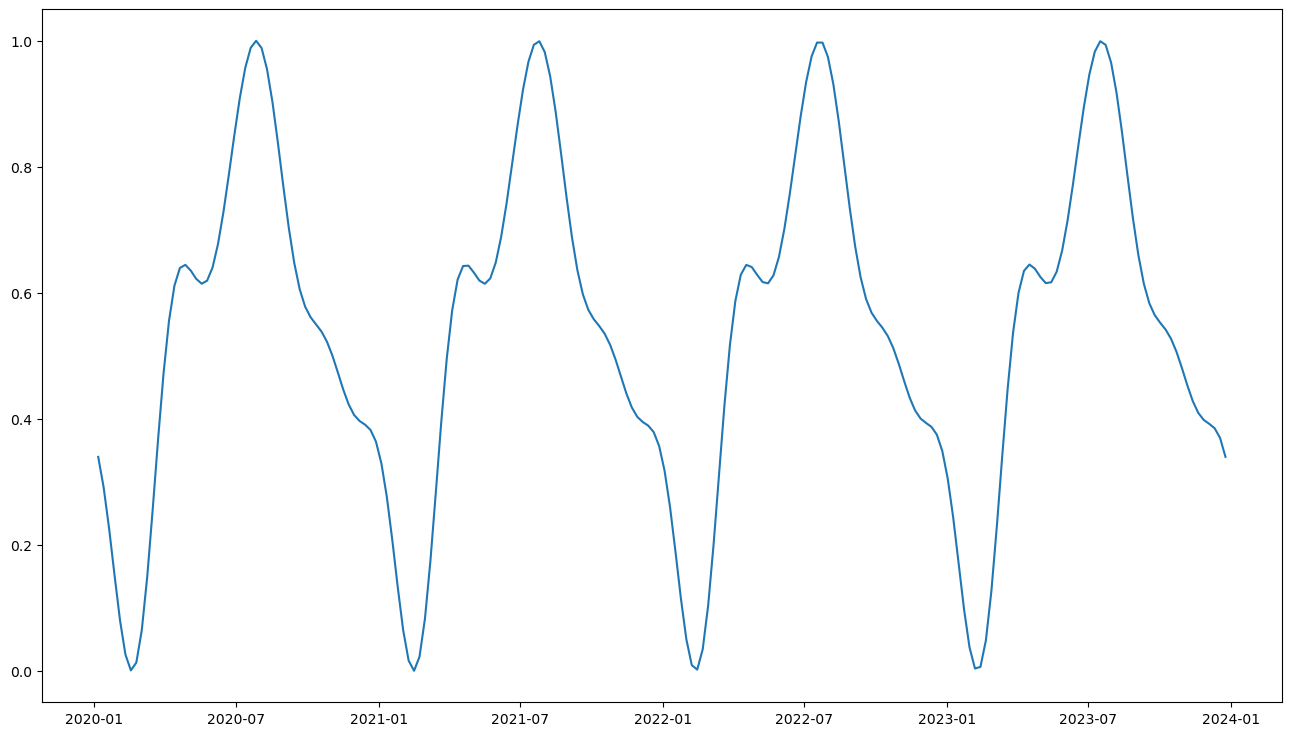

In [5]:
t = np.linspace(0, N_YEARS*2*np.pi, N_WEEKS_PER_YEAR*N_YEARS)
FOURIER_COMPONENTS = 5
fourier_data = np.vstack([np.sin(t*(i+1))/factorial(i) for i in range(FOURIER_COMPONENTS)] + [np.cos(t*(i+1))/factorial(i) for i in range(FOURIER_COMPONENTS)])
fourier_betas = np.random.normal(0, 1, (2*FOURIER_COMPONENTS))
season = np.dot(fourier_data.T, fourier_betas)
season = (season - np.min(season))/(np.max(season) - np.min(season))
plt.figure(figsize=(16, 9))
plt.plot(date, season)

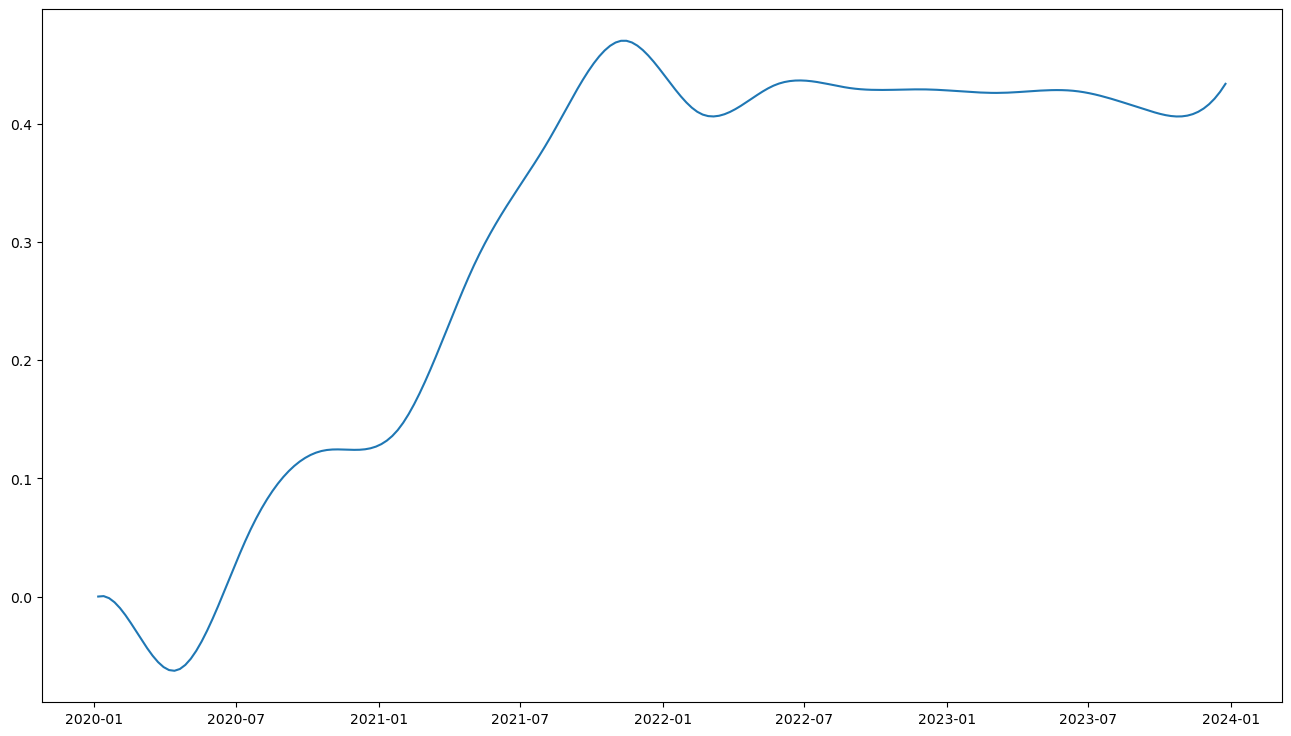

In [6]:
knots = np.linspace(0, 1, 4*N_YEARS)[1:-1]
splines = np.asarray(dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)-1", 
        {"x": np.linspace(0, 1, N_WEEKS_PER_YEAR*N_YEARS), "knots": knots}))
splines_betas = np.random.normal(.02, .1, (splines.shape[1])).cumsum()
trend = np.dot(splines, splines_betas)
plt.figure(figsize=(16, 9))
plt.plot(date, trend)

In [7]:
from itertools import product

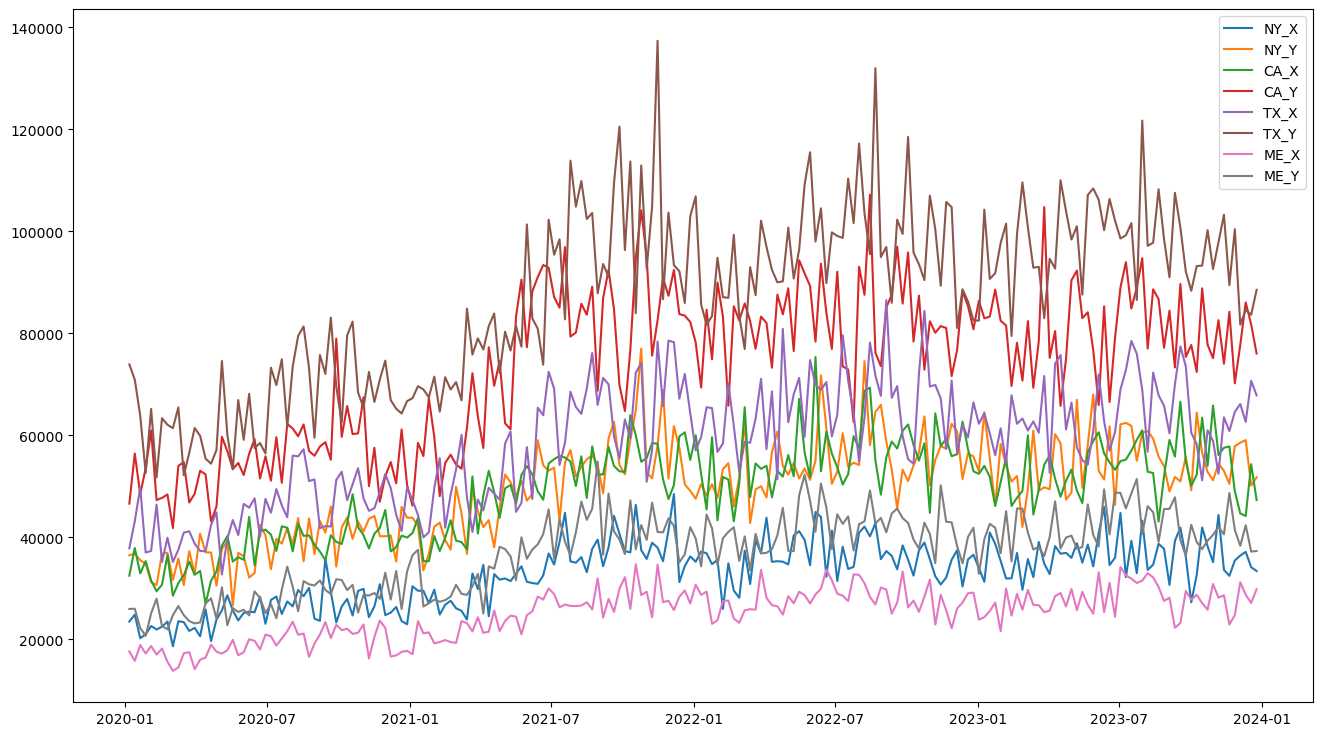

In [8]:
plt.figure(figsize=(16, 9))
for geo, prod in product(geographies, products):
  plt.plot(
    date, 
    np.exp(
      10 + np.log(geography_size[geo])
      + np.log(product_importance[prod])
      + 0.15*season + trend 
      + np.random.normal(0, 0.1, N_WEEKS_PER_YEAR*N_YEARS)),
      label=f"{geo}_{prod}")
plt.legend()


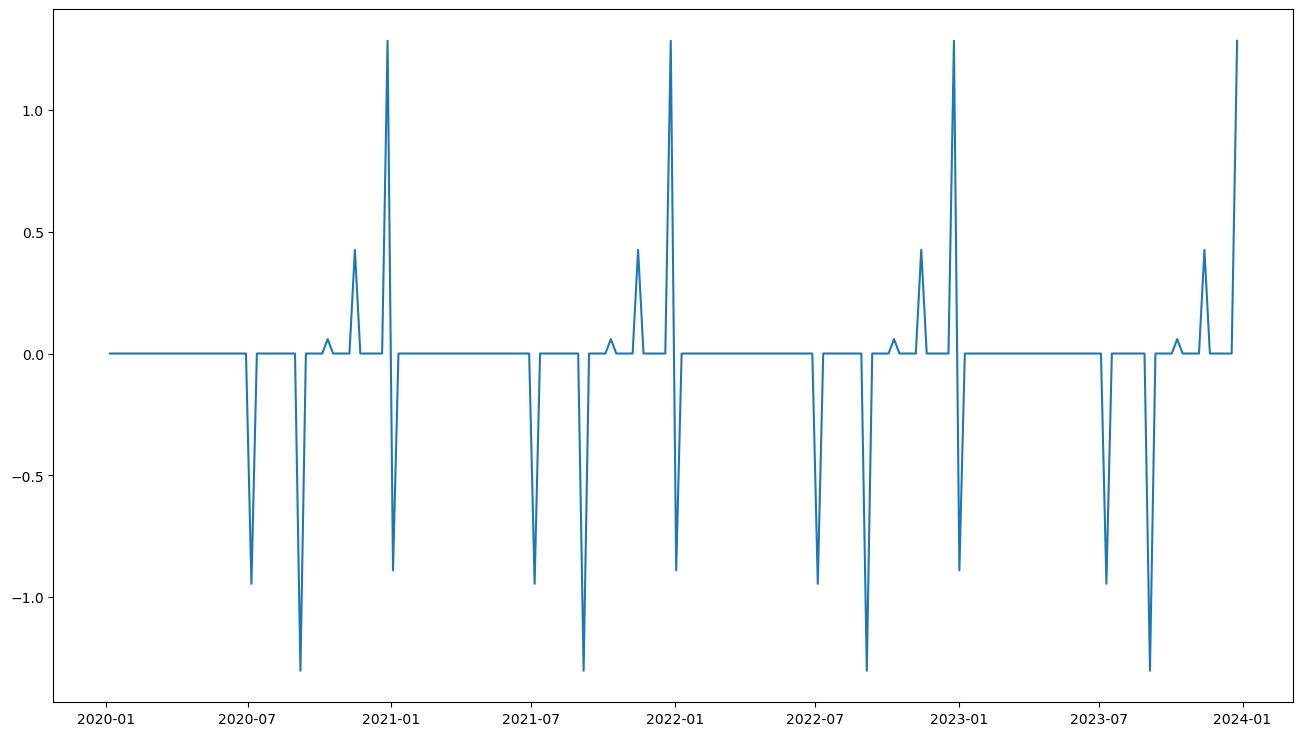

In [9]:
N_holidays = len(holidays.columns)
holiday_beta = np.random.normal(0, 1, (N_holidays)) * np.random.choice([0, 1], p=[.7, .3], size=N_holidays)
holiday_effect = np.dot(holidays.values, holiday_beta)
plt.figure(figsize=(16, 9))
plt.plot(date, holiday_effect)


In [10]:
season_xr = xr.DataArray(season, dims=("time",), coords={"time": date}, name="season")
trend_xr = xr.DataArray(trend, dims=("time",), coords={"time": date}, name="trend")
geography_offset_xr = xr.DataArray(
  np.log(
    np.array(
      list(geography_size.values())
      )
    ), 
  dims=("geography",), 
  coords={"geography": list(geographies)},
  name="geography_offset")
product_offset_xr = xr.DataArray(
  np.log(
    np.array(
      list(product_importance.values())
      )
    ), 
  dims=("product",),
  coords={"product": list(product_importance.keys())}, 
  name="product_offset")
holiday_xr = xr.DataArray(holidays.values, dims=("time", "holiday"), coords={"time": date, "holiday": holidays.columns}, name="holiday")
holiday_beta_xr = xr.DataArray(holiday_beta, dims=("holiday",), coords={"holiday": holidays.columns}, name="holiday_beta")

holiday_heteroskedasticity = xr.DataArray(
  np.random.normal(0, 0.1, 
    size=(N_WEEKS_PER_YEAR*N_YEARS, N_holidays))
  , dims=("time", "holiday"), 
  coords={"time": date, "holiday": holidays.columns})
holiday_effect_xr = holiday_effect_xr = xr.dot(holiday_xr, holiday_beta_xr + holiday_heteroskedasticity*(holiday_beta_xr>0), dims=["holiday"])
holiday_effect_xr = holiday_effect_xr.rename("holiday_effect")

base = np.exp(10 + 0.15*season_xr + trend_xr + geography_offset_xr + product_offset_xr + .3*holiday_effect_xr)
base = base.rename("base")

In [11]:
from scipy import special as sps

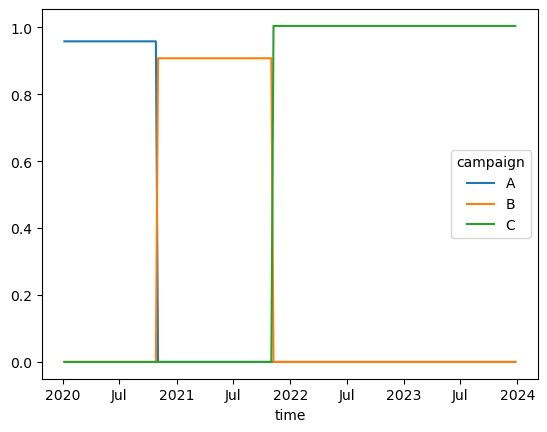

In [12]:
campaign_time = np.zeros((N_WEEKS_PER_YEAR*N_YEARS, len(campaigns)))
campaign_time[date<=pd.to_datetime("2020-11-01"), 0] = 1
campaign_time[(date>pd.to_datetime("2020-11-01")) & (date<=pd.to_datetime("2021-11-01")), 1] = 1
campaign_time[date>pd.to_datetime("2021-11-01"), 2] = 1
campaign_time_xr = xr.DataArray(campaign_time, dims=("time", "campaign"), coords={"time": date, "campaign": campaigns}, name="campaign_time")
campaign_weights = xr.DataArray(np.random.lognormal(0, .2, (len(campaigns),)), dims=("campaign",), coords={"campaign": campaigns}, name="campaign_weights")
campaign_effect = campaign_time_xr*campaign_weights
campaign_effect.plot.line(x="time")

In [13]:
olv_outlets_xr = xr.DataArray(
  [outlet_size[outlet] for outlet in olv_outlets], 
  dims=("olv_outlet",), 
  coords={"olv_outlet": olv_outlets}, 
  name="olv_outlets"
  )
olv_creatives_xr = xr.DataArray(
  [creative_size[creative] for creative in olv_creatives], 
  dims=("olv_creative",), 
  coords={"olv_creative": olv_creatives}, 
  name="olv_creatives"
  )

audio_creatives_xr = xr.DataArray(
  [creative_size[creative] for creative in audio_creatives], 
  dims=("audio_creative",), 
  coords={"audio_creative": audio_creatives}, 
  name="audio_creatives"
  )
audio_outlets_xr = xr.DataArray(
  [outlet_size[outlet] for outlet in audio_outlets], 
  dims=("audio_outlet",), 
  coords={"audio_outlet": audio_outlets}, 
  name="audio_outlets")

social_outlets_xr = xr.DataArray(
  [outlet_size[outlet] for outlet in social_outlets], 
  dims=("social_outlet",), 
  coords={"social_outlet": social_outlets}, 
  name="social_outlets")
social_creatives_xr = xr.DataArray(
  [creative_size[creative] for creative in social_creatives], 
  dims=("social_creative",), 
  coords={"social_creative": social_creatives}, 
  name="social_creatives")

display_outlets_xr = xr.DataArray(
  [outlet_size[outlet] for outlet in display_outlets], 
  dims=("display_outlet",), 
  coords={"display_outlet": display_outlets}, 
  name="display_outlets")
display_creatives_xr = xr.DataArray(
  [creative_size[creative] for creative in display_creatives], 
  dims=("display_creative",), 
  coords={"display_creative": display_creatives}, 
  name="display_creatives")

search_outlets_xr = xr.DataArray(
  [outlet_size[outlet] for outlet in search_outlets], 
  dims=("search_outlet",), 
  coords={"search_outlet": search_outlets}, 
  name="search_outlets")
search_creatives_xr = xr.DataArray(
  [creative_size[creative] for creative in search_creatives], 
  dims=("search_creative",), 
  coords={"search_creative": search_creatives}, 
  name="search_creatives")

In [14]:
media_planning_base = (
  .05*trend_xr + 2*season_xr 
  + 0.5*geography_offset_xr 
  + 2*product_offset_xr 
  + 0.5*holiday_effect_xr
  + np.log(campaign_effect))

base_olv_impressions = np.exp(
  media_planning_base
  + np.log(olv_outlets_xr)
  + np.log(olv_creatives_xr)
  + xr.DataArray(np.random.normal(0, .2, (N_WEEKS_PER_YEAR*N_YEARS, len(geographies), len(products), len(olv_outlets), len(olv_creatives))), 
    dims=("time","geography","product", "olv_outlet", "olv_creative"), 
    coords={
      "time": date, "geography":geographies,
      "olv_outlet": olv_outlets, 
      "olv_creative": olv_creatives,
      "product": products}).rename("olv_noise")
  )
base_olv_impressions = base_olv_impressions.rename("base_olv_impressions")

base_social_impressions = np.exp(
  media_planning_base
  + np.log(social_outlets_xr)
  + np.log(social_creatives_xr)
  + xr.DataArray(np.random.normal(0, .2, (N_WEEKS_PER_YEAR*N_YEARS,len(geographies), len(products), len(social_outlets), len(social_creatives))),  
    dims=("time", "geography", "product", "social_outlet", "social_creative"), 
    coords={"time": date, "geography": geographies, "product": products, "social_outlet": social_outlets, "social_creative": social_creatives}).rename("social_noise")
  )
base_social_impressions = base_social_impressions.rename("base_social_impressions")

base_audio_impressions = np.exp(
  media_planning_base
  + np.log(audio_outlets_xr)
  + np.log(audio_creatives_xr)
  + xr.DataArray(np.random.normal(0, .2, (N_WEEKS_PER_YEAR*N_YEARS,len(geographies), len(products), len(audio_outlets), len(audio_creatives))), 
    dims=("time","geography", "product", "audio_outlet", "audio_creative"), 
    coords={"time": date, "geography": geographies, "product": products, "audio_outlet": audio_outlets, "audio_creative": audio_creatives}).rename("audio_noise")
  )
base_audio_impressions = base_audio_impressions.rename("base_audio_impressions")

base_display_impressions = np.exp(
  media_planning_base
  + np.log(display_outlets_xr)
  + np.log(display_creatives_xr)
  + xr.DataArray(np.random.normal(0, .2, (N_WEEKS_PER_YEAR*N_YEARS,len(geographies), len(products), len(display_outlets), len(display_creatives))),
    dims=("time", "geography", "product", "display_outlet", "display_creative"), 
    coords={"time": date, "geography": geographies, "product": products, "display_outlet": display_outlets, "display_creative": display_creatives}).rename("display_noise")
  )
base_display_impressions = base_display_impressions.rename("base_display_impressions")

/home/mattr/miniforge3/envs/bayesinsight/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [15]:
def impressions_from_base(base, alpha, beta,p_stretch, p, dims, coords):
  return xr.DataArray(
    (np.random.gamma(alpha, beta*base)
     * np.random.binomial(1, sps.expit(p_stretch*base+p))
     ),
    dims=dims,
    coords=coords
  )

In [16]:
shared_coords = {
  "time": date, 
  "geography": list(geographies), 
  "product": list(products),
  "campaign": list(campaigns),
  }
shared_dims = [
  "time", "geography", "product", "campaign"
  ]


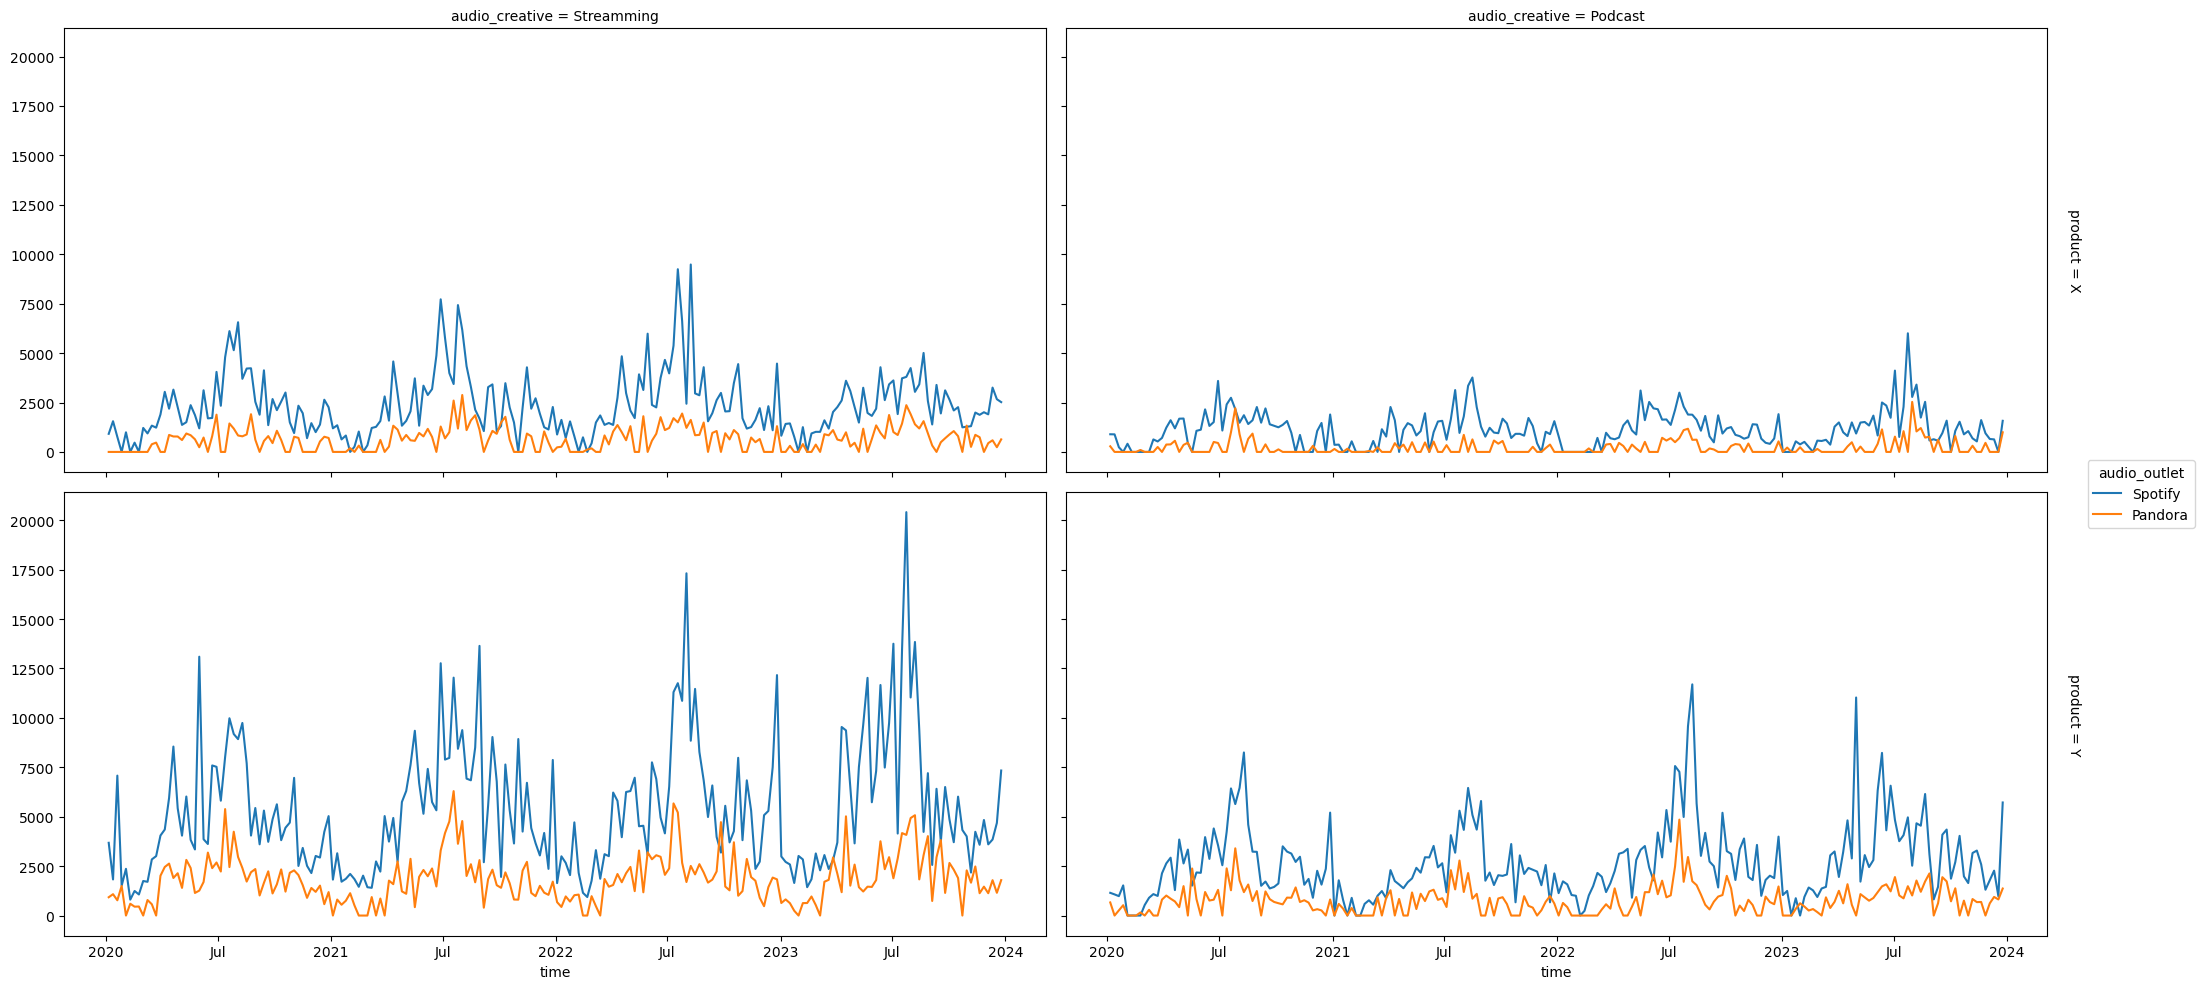

In [17]:
audio_coords = shared_coords | {"audio_outlet": audio_outlets, "audio_creative": audio_creatives}
audio_dims = tuple(shared_dims + ["audio_outlet", "audio_creative"])
audio_impressions = impressions_from_base(base_audio_impressions, 10, 50, 2, -2, audio_dims, audio_coords)
(audio_impressions
 .sum(dim="campaign")
 .sel(geography="NY")
 .plot
 .line(x="time", hue='audio_outlet', col="audio_creative",row="product", aspect=2, size=5)
)

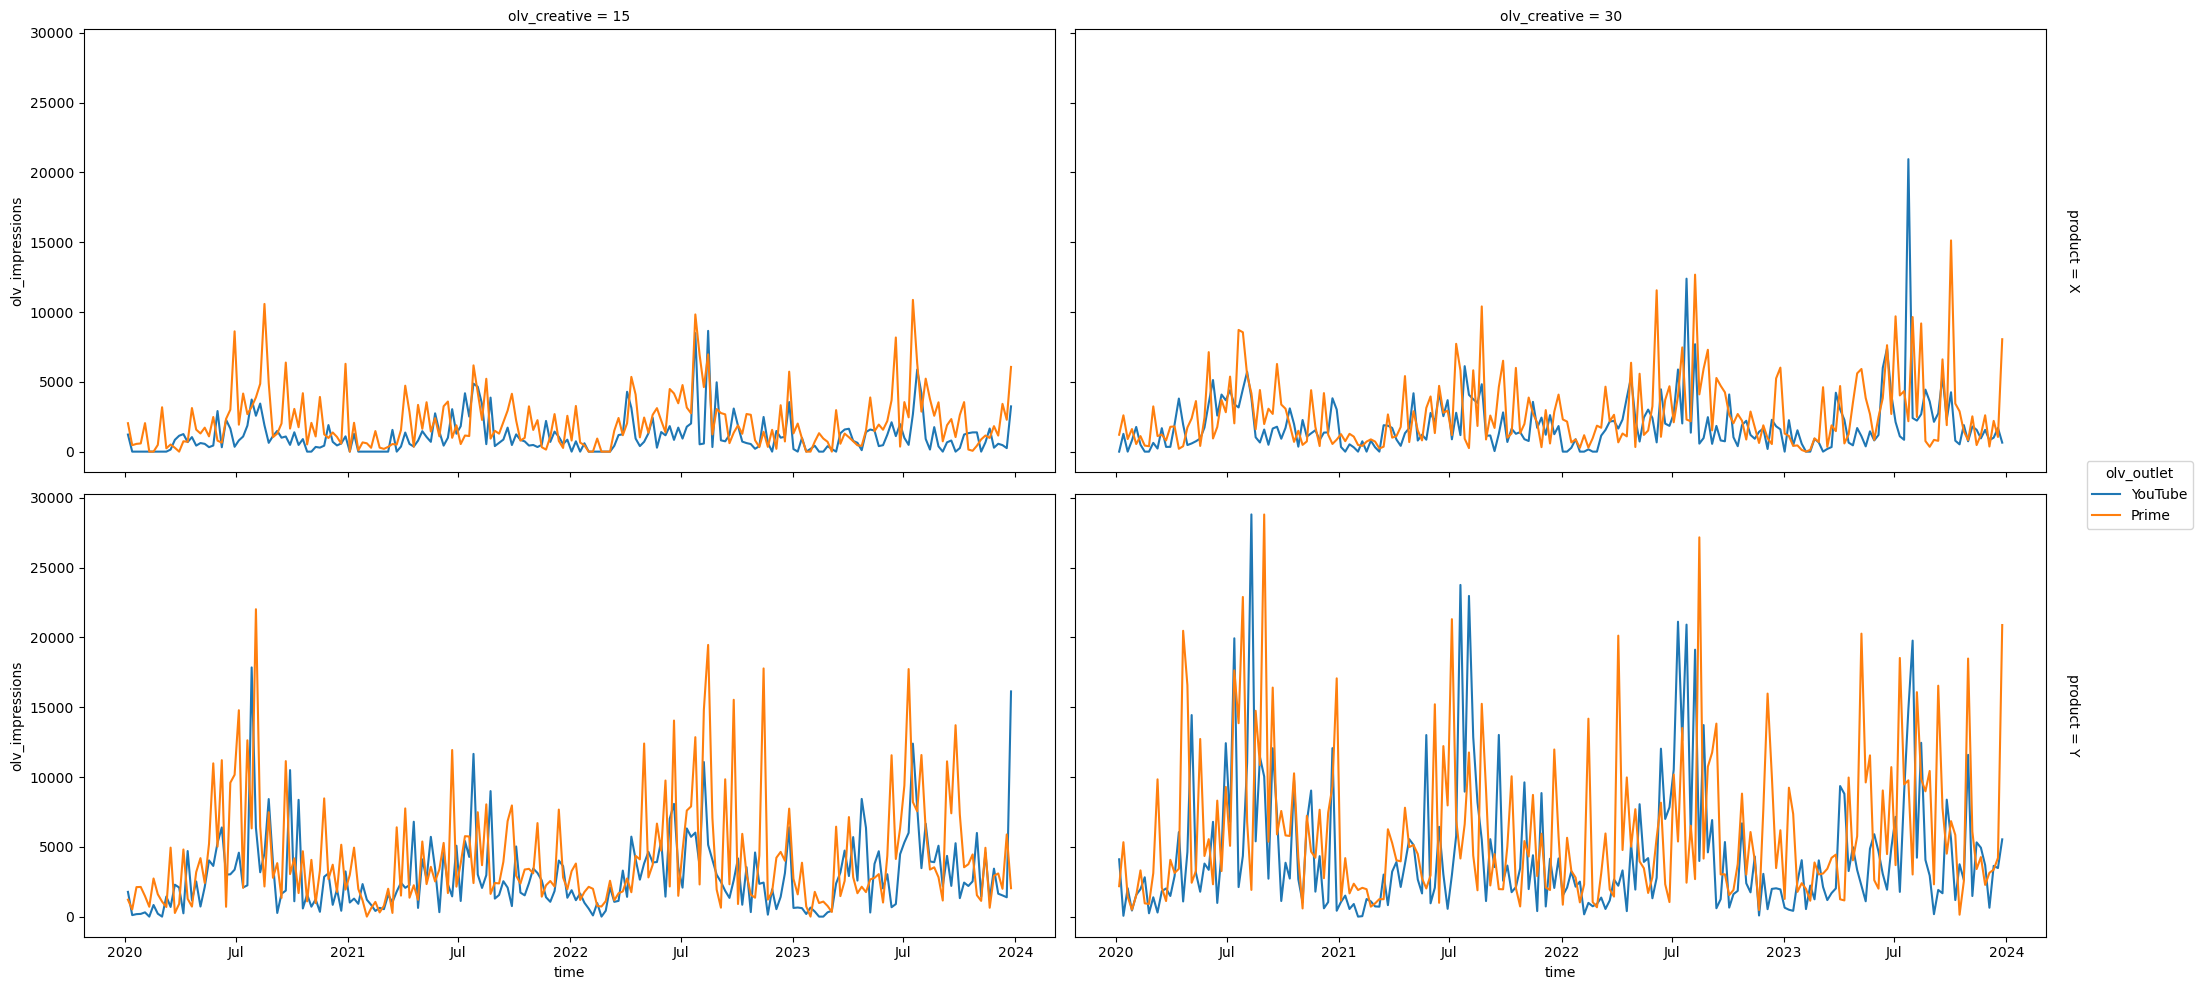

In [18]:
olv_coords = shared_coords | {"olv_outlet": olv_outlets, "olv_creative": olv_creatives}
olv_dims = tuple(shared_dims + ["olv_outlet", "olv_creative"])
olv_impressions = impressions_from_base(
  base_olv_impressions, 
  2, 200, 3, -5, olv_dims, olv_coords
  ).rename("olv_impressions")

(olv_impressions
 .sum(dim='campaign')
 .sel(geography='NY')
 .plot
 .line(x="time", hue="olv_outlet", col="olv_creative", row="product", aspect=2, size=5))

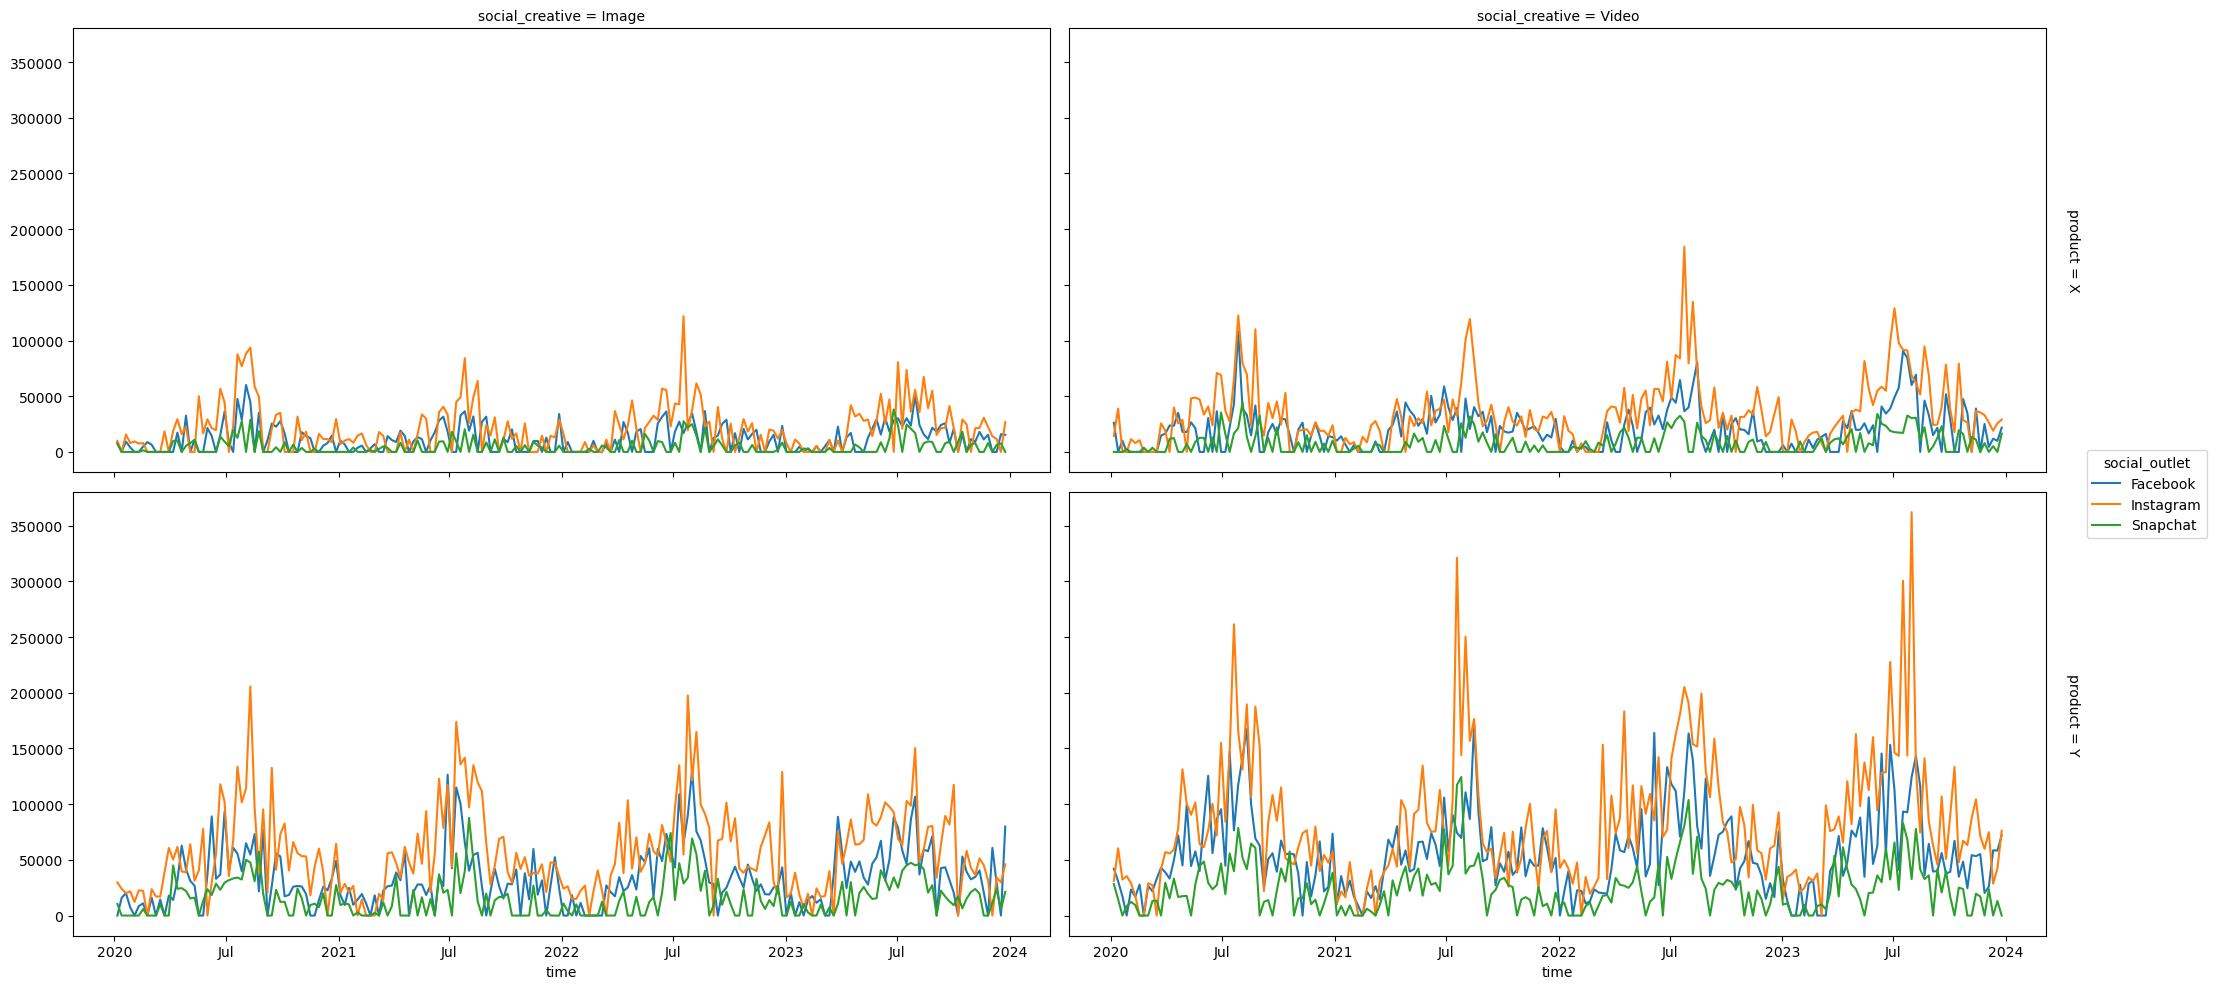

In [19]:
social_coords = shared_coords | {"social_outlet": social_outlets, "social_creative": social_creatives}
social_dims = tuple(shared_dims + ["social_outlet", "social_creative"])
social_impressions = impressions_from_base(base_social_impressions, 10, 500, .5,  -1, social_dims, social_coords)
(social_impressions
 .sum(dim="campaign")
 .sel(geography="NY")
 .plot
 .line(x="time", hue='social_outlet', col="social_creative", row="product", aspect=2, size=5)
)

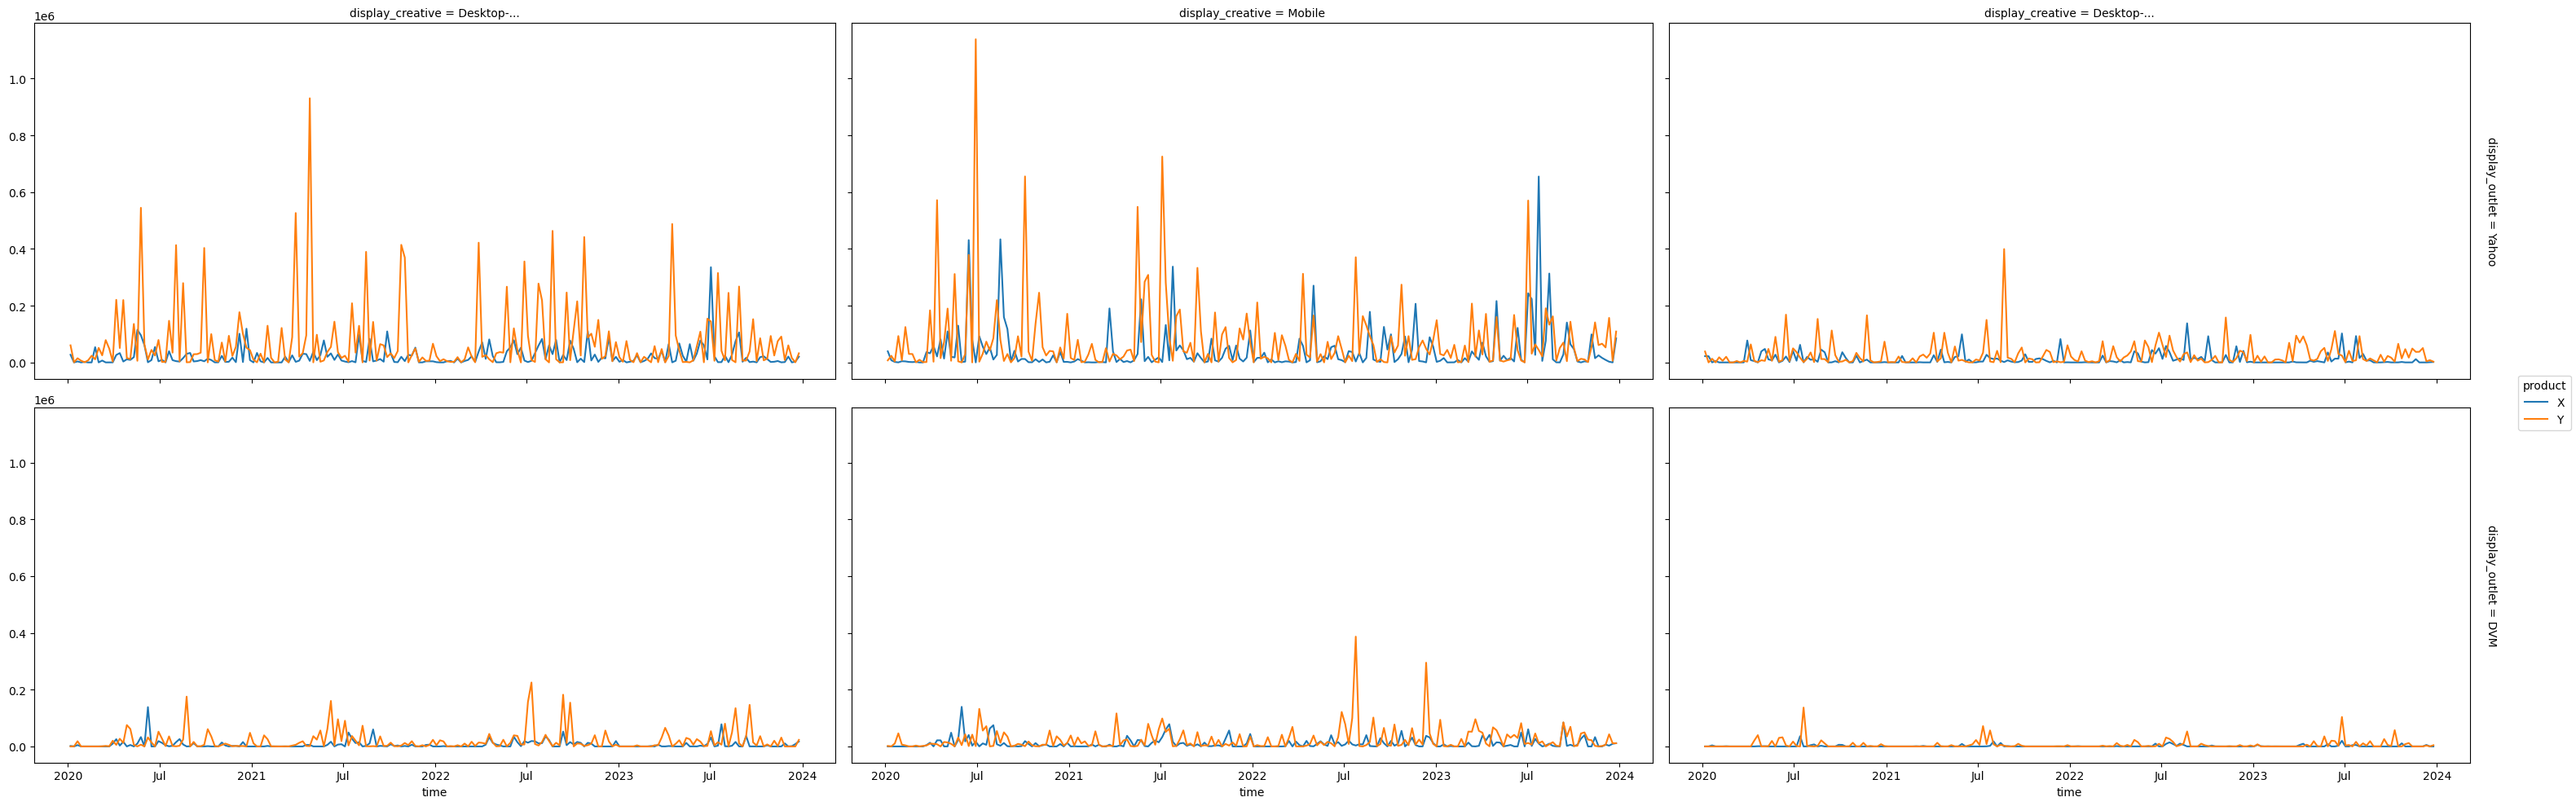

In [20]:
display_coords = shared_coords | {"display_outlet": display_outlets, "display_creative": display_creatives}
display_dims = tuple(shared_dims + ["display_outlet", "display_creative"])
display_impressions = 1000*impressions_from_base(
  base_display_impressions, .5, 5, 
  1, -3, display_dims, display_coords)
(display_impressions
 .sum(dim="campaign")
 .sel(geography="NY")
 .plot
 .line(x="time", hue='product', col="display_creative", row="display_outlet", aspect=2, size=5)
)

In [21]:
def hill(x, k, n):
  return x**n/(k**n + x**n)

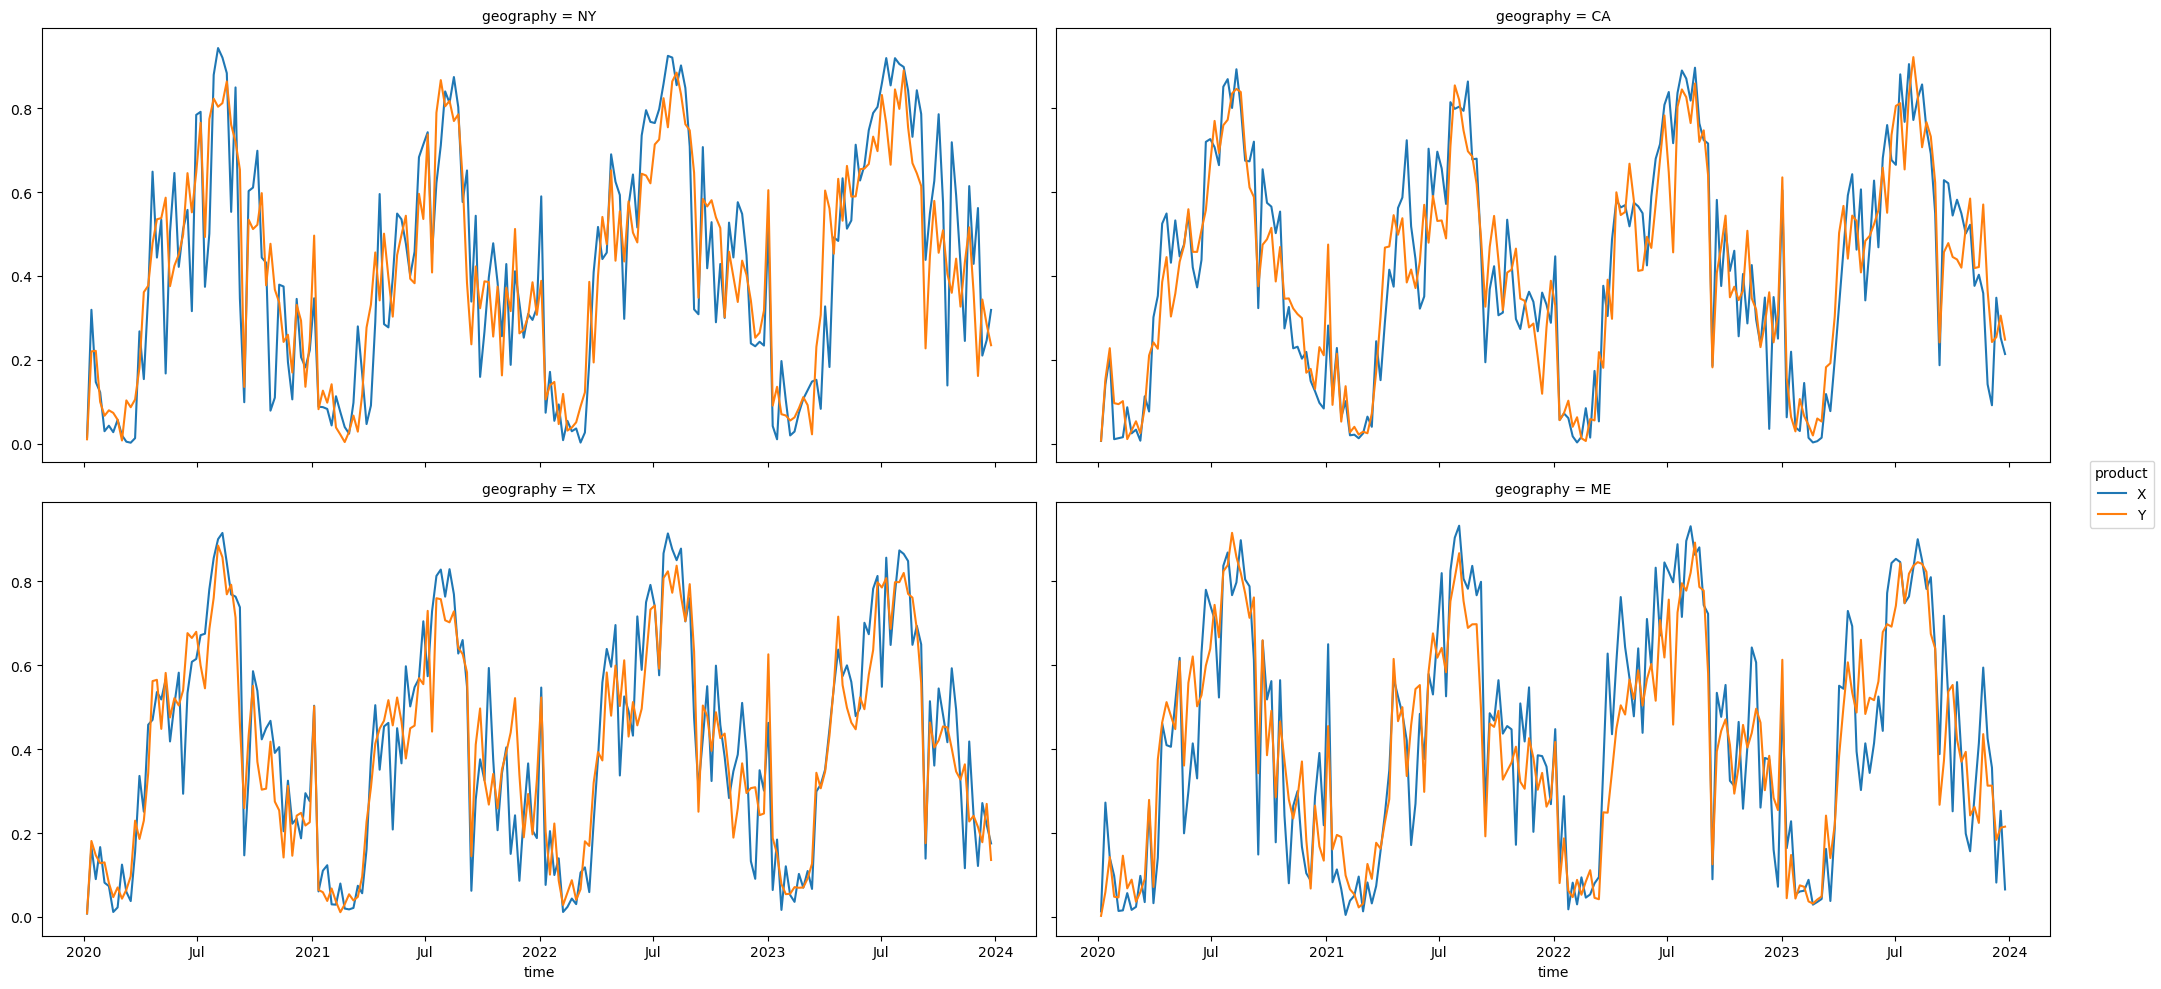

In [22]:
social_campaign_weights = xr.DataArray(
  np.random.lognormal(0, .1, (len(campaigns), len(social_outlets), len(social_creatives))),
  dims=("campaign", "social_outlet", "social_creative"),
  coords={"campaign": campaigns, "social_outlet": social_outlets, "social_creative": social_creatives},
  name="social_campaign_weights"
  )
social_medians = social_impressions.where(social_impressions>0).sum(dim=("campaign", "social_outlet", "social_creative")).median(dim="time")
hill_social = hill(xr.dot(social_impressions, social_campaign_weights, dims=["campaign", "social_outlet", "social_creative"])/social_medians, 1.2, 2)
adstock_hill_social = delayed_adstock(hill_social.values, 0.05, 1, normalize=True).eval()
adstock_hill_social = xr.DataArray(
  adstock_hill_social,
  dims=('time', 'geography', 'product'),
  coords={'time': date, 'geography': list(geographies), 'product': list(products)}
)
adstock_hill_social.plot.line(x="time", hue='product', col='geography',col_wrap=2, aspect=2, size=5)

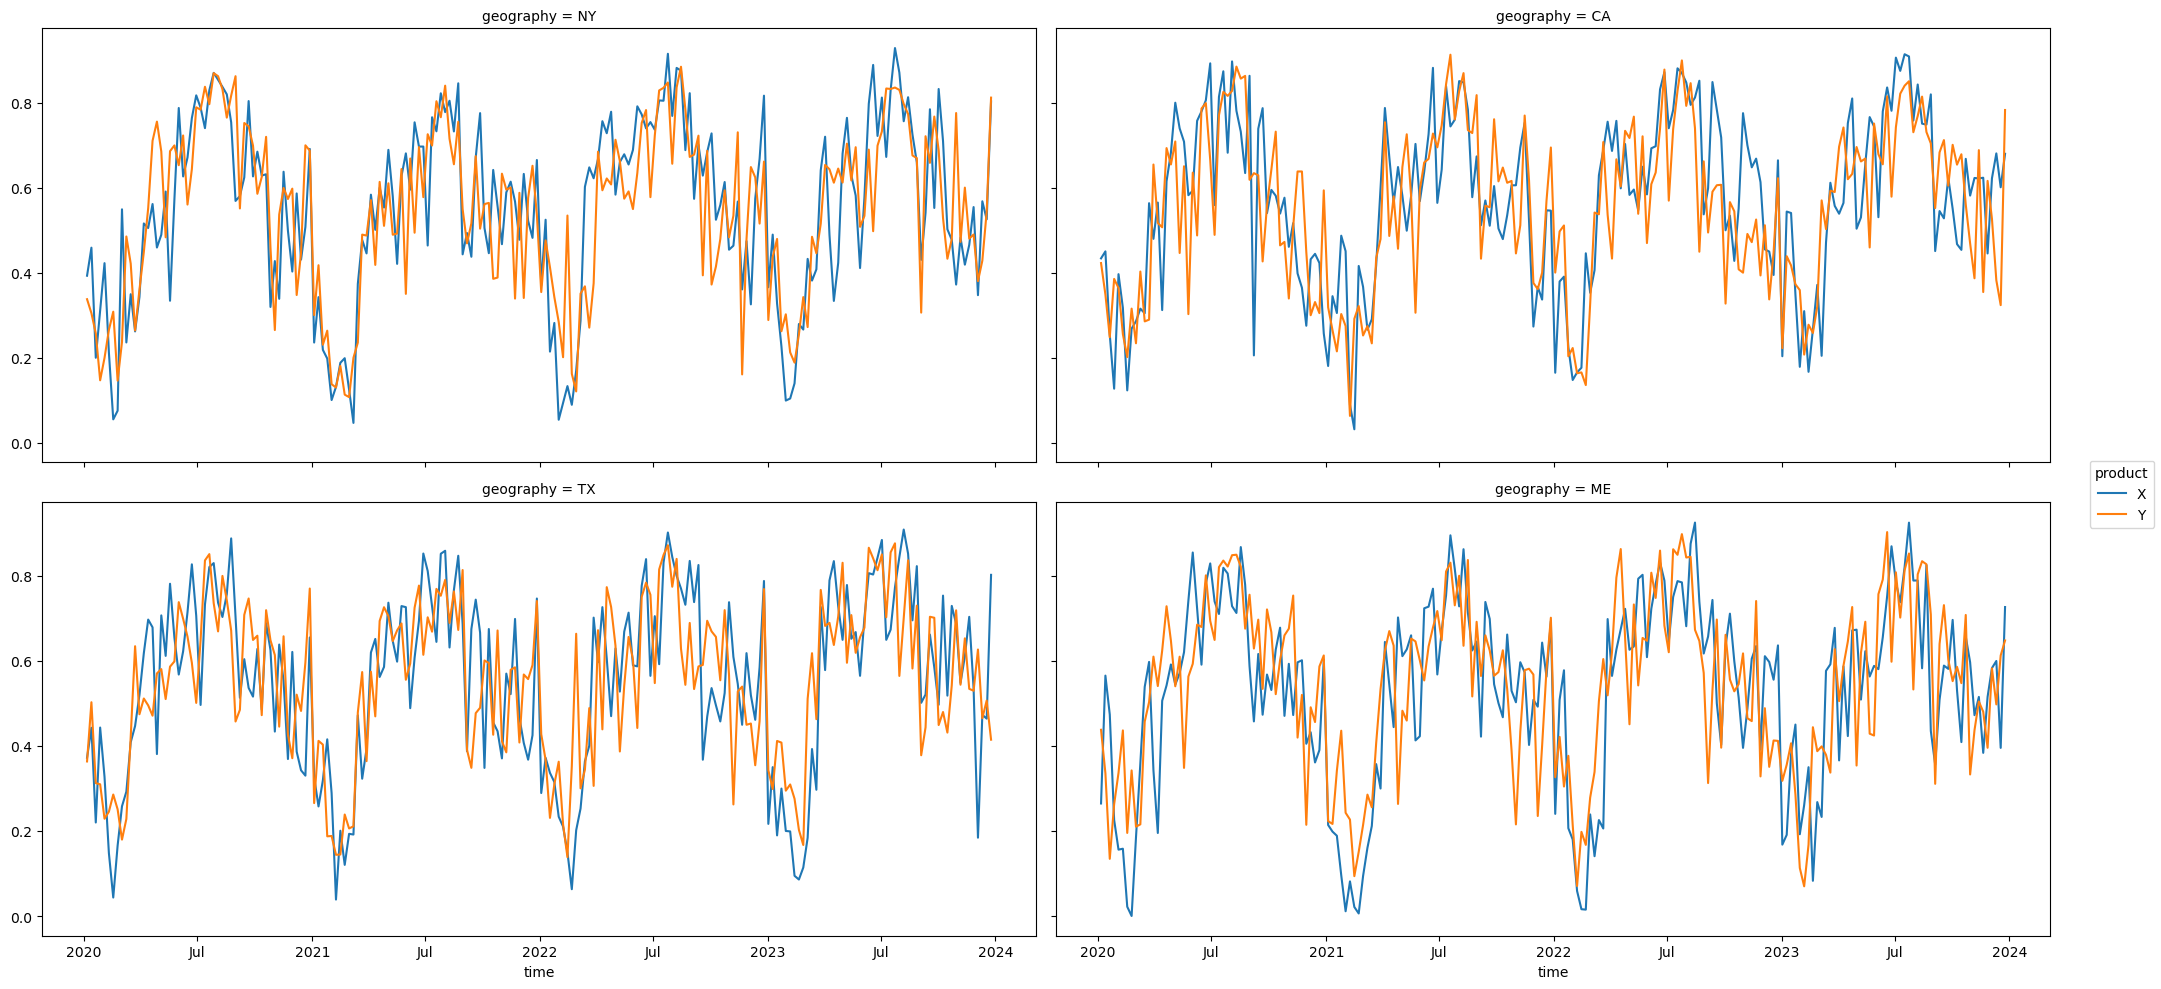

In [23]:
olv_campaign_weights = xr.DataArray(
  np.random.lognormal(0, .1, (len(campaigns), len(olv_outlets), len(olv_creatives))),
  dims=("campaign", "olv_outlet", "olv_creative"),
  coords={"campaign": campaigns, "olv_outlet": olv_outlets, "olv_creative": olv_creatives},
  name="olv_campaign_weights"
  )
olv_medians = olv_impressions.where(olv_impressions>0).sum(dim=("campaign", "olv_outlet", "olv_creative")).median(dim="time")
hill_olv = hill(xr.dot(olv_impressions, olv_campaign_weights, dims=["campaign", "olv_outlet", "olv_creative"])/olv_medians, .8, 1.4)
adstock_hill_olv = delayed_adstock(hill_olv.values, 0.1, 0.1, normalize=True).eval()
adstock_hill_olv = xr.DataArray(
  adstock_hill_olv,
  dims=('time', 'geography', 'product'),
  coords={'time': date, 'geography': list(geographies), 'product': list(products)}
)
adstock_hill_olv.plot.line(x="time", hue='product', col='geography', col_wrap=2, aspect=2, size=5)

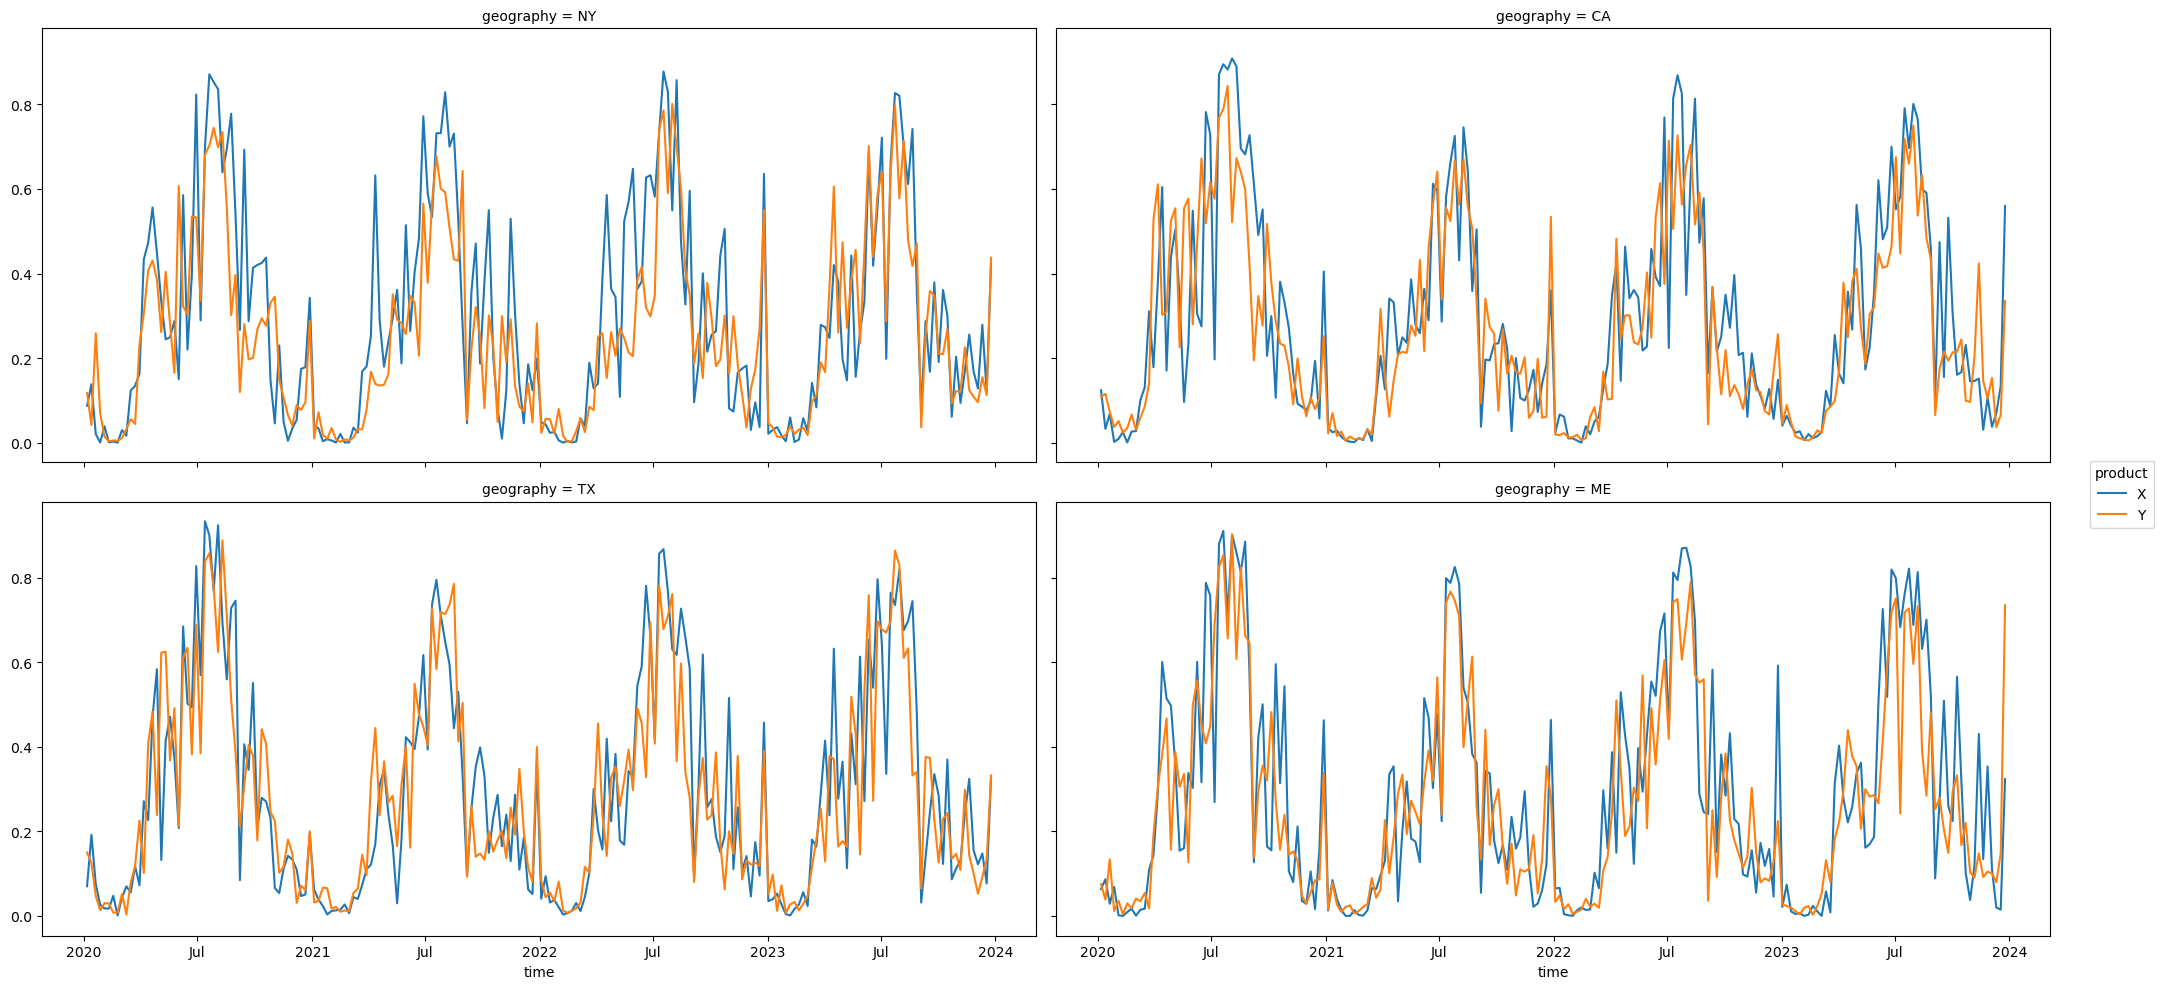

In [24]:
audio_campaign_weights = xr.DataArray(
  np.random.lognormal(0, .1, (len(campaigns), len(audio_outlets), len(audio_creatives))),
  dims=("campaign", "audio_outlet", "audio_creative"),
  coords={"campaign": campaigns, "audio_outlet": audio_outlets, "audio_creative": audio_creatives},
  name="audio_campaign_weights"
  )
audio_medians = audio_impressions.where(audio_impressions>0).sum(dim=("campaign", "audio_outlet", "audio_creative")).median(dim="time")
hill_audio = hill(xr.dot(audio_impressions, audio_campaign_weights, dims=["campaign", "audio_outlet", "audio_creative"])/audio_medians, 1.6, 2.5)
adstock_hill_audio = delayed_adstock(hill_audio.values, 0.01, 0.1, normalize=True).eval()
adstock_hill_audio = xr.DataArray(
  adstock_hill_audio,
  dims=('time', 'geography', 'product'),
  coords={'time': date, 'geography': list(geographies), 'product': list(products)}
)
adstock_hill_audio.plot.line(x="time", hue='product', col='geography', col_wrap=2, aspect=2, size=5)

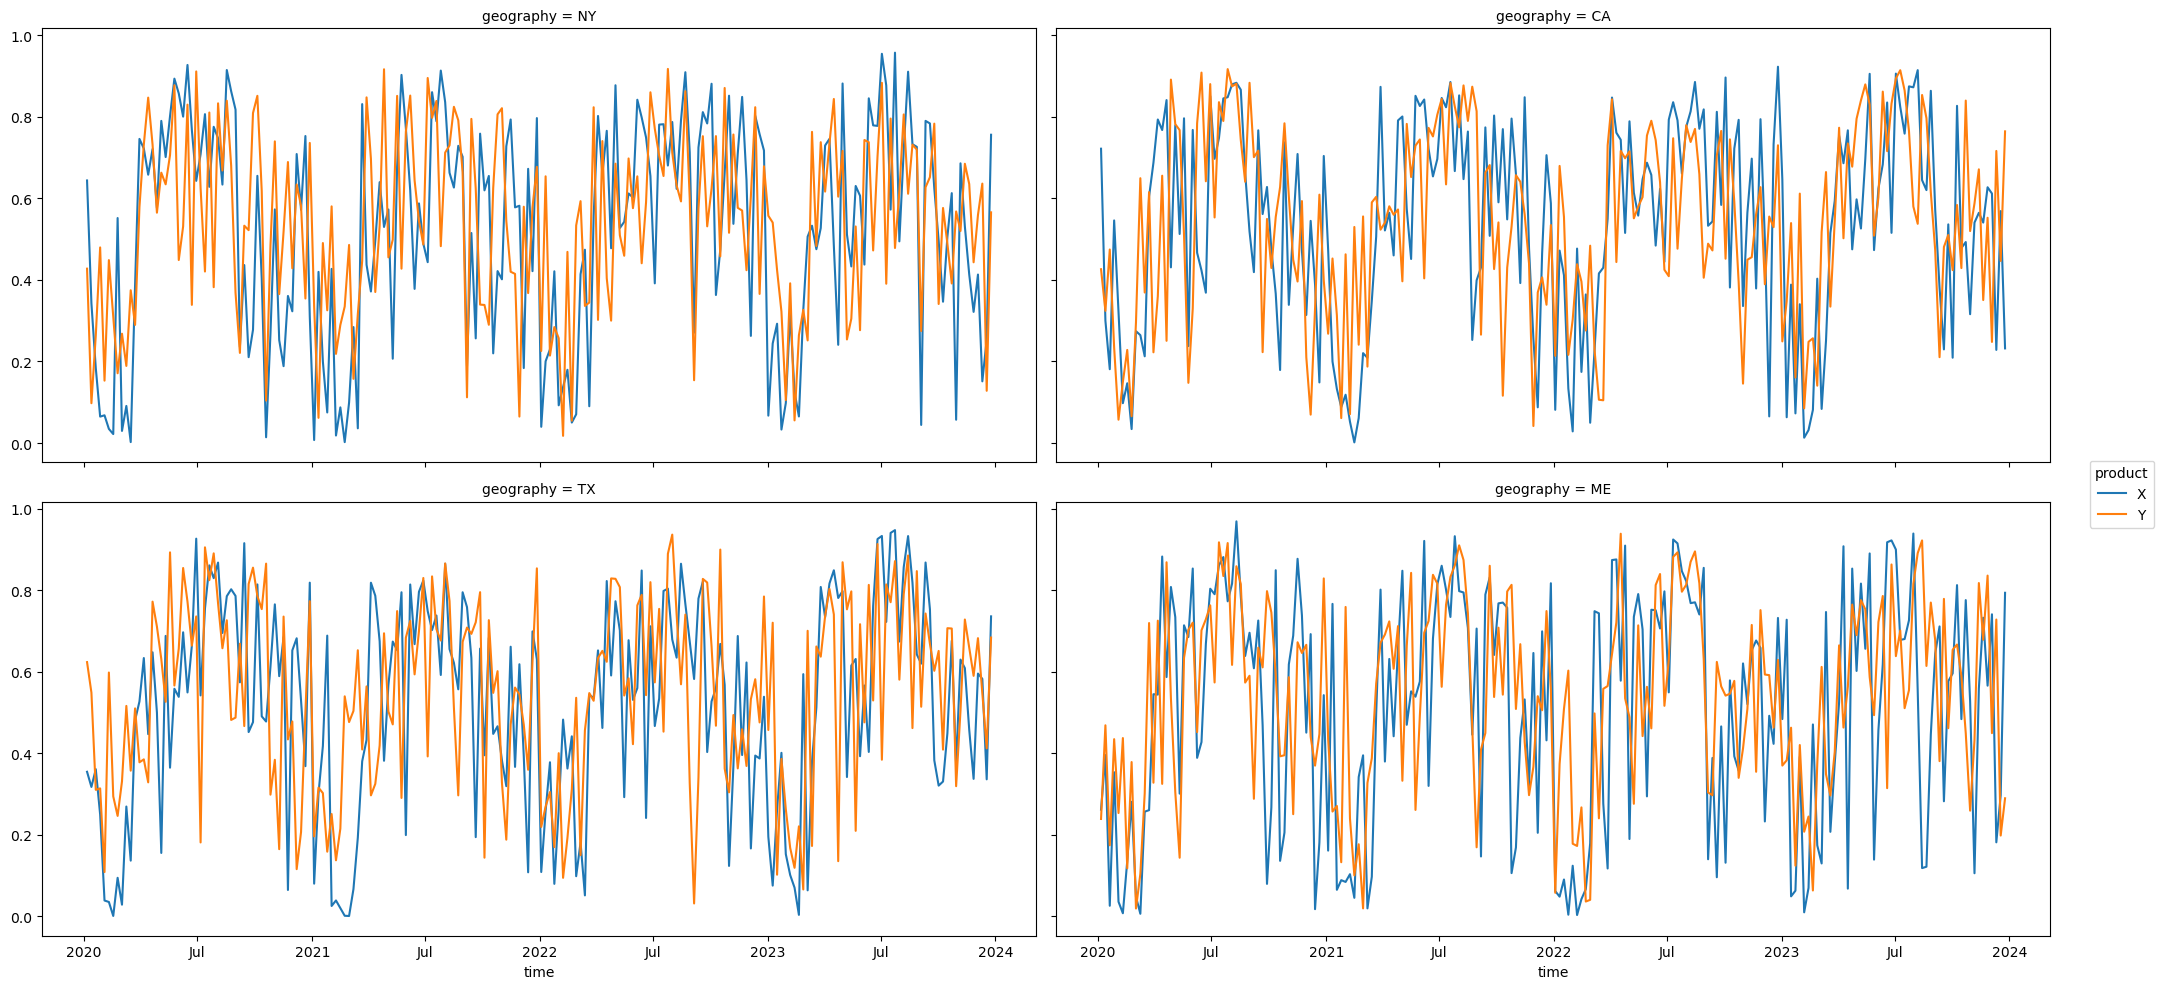

In [25]:
display_campaign_weights = xr.DataArray(
  np.random.lognormal(0, .1, (len(campaigns), len(display_outlets), len(display_creatives))),
  dims=("campaign", "display_outlet", "display_creative"),
  coords={"campaign": campaigns, "display_outlet": display_outlets, "display_creative": display_creatives},
  name="display_campaign_weights"
  )
display_medians = display_impressions.where(display_impressions>0).sum(dim=("campaign", "display_outlet", "display_creative")).median(dim="time")
hill_display = hill(xr.dot(display_impressions, display_campaign_weights, dims=["campaign", "display_outlet", "display_creative"])/display_medians, 0.8, 1.2)
adstock_hill_display = delayed_adstock(hill_display.values, 0.01, 0.1, normalize=True).eval()
adstock_hill_display = xr.DataArray(
  adstock_hill_display,
  dims=('time', 'geography', 'product'),
  coords={'time': date, 'geography': list(geographies), 'product': list(products)}
)
adstock_hill_display.plot.line(x="time", hue='product', col='geography', col_wrap=2, aspect=2, size=5)

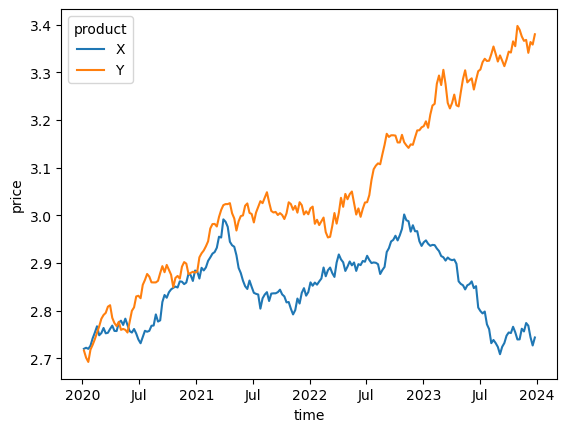

In [26]:
price = np.exp(np.random.normal(0.001, 0.005, size=(N_WEEKS_PER_YEAR*N_YEARS, len(products))).cumsum(axis=0)+1)
price = xr.DataArray(price, dims=("time", "product"), coords={"time": date, "product": products}, name="price")
price.plot.line(x="time", hue="product")

In [27]:
base_effect = np.exp(np.log(base) - .8*np.log(price) + np.random.normal(0, .1, base.shape))
olv_effects_xr = xr.DataArray(
  0.2 + np.random.normal(0, .03, (len(geographies), len(products))),
  dims=("geography", "product"),
  coords={"geography": list(geographies), "product": list(products)},
  name="olv_effects"
  )
social_effects_xr = xr.DataArray(
  0.1 + np.random.normal(0, .01, (len(geographies), len(products))),
  dims=("geography", "product"),
  coords={"geography": list(geographies), "product": list(products)},
  name="social_effects"
  )
audio_effects_xr = xr.DataArray(
  0.15 + np.random.normal(0, .03, (len(geographies), len(products))),
  dims=("geography", "product"),
  coords={"geography": list(geographies), "product": list(products)},
  name="audio_effects"
  )
display_effects_xr = xr.DataArray(
  0.05 + np.random.normal(0, .005, (len(geographies), len(products))),
  dims=("geography", "product"),
  coords={"geography": list(geographies), "product": list(products)},
  name="display_effects"
  )

unit_sales = np.exp(
  olv_effects_xr*adstock_hill_olv 
  + social_effects_xr*adstock_hill_social 
  + audio_effects_xr*adstock_hill_audio 
  + display_effects_xr*adstock_hill_display 
  + np.log(base_effect)
  )
unit_sales = unit_sales.rename("unit_sales")
sales = price*unit_sales

In [28]:
olv_effects_xr

<xarray.DataArray 'olv_effects' (geography: 4, product: 2)> Size: 64B
array([[0.23133496, 0.22786398],
       [0.20734514, 0.23465996],
       [0.16387096, 0.23521582],
       [0.16223969, 0.18913807]])
Coordinates:
  * geography  (geography) <U2 32B 'NY' 'CA' 'TX' 'ME'
  * product    (product) <U1 8B 'X' 'Y'

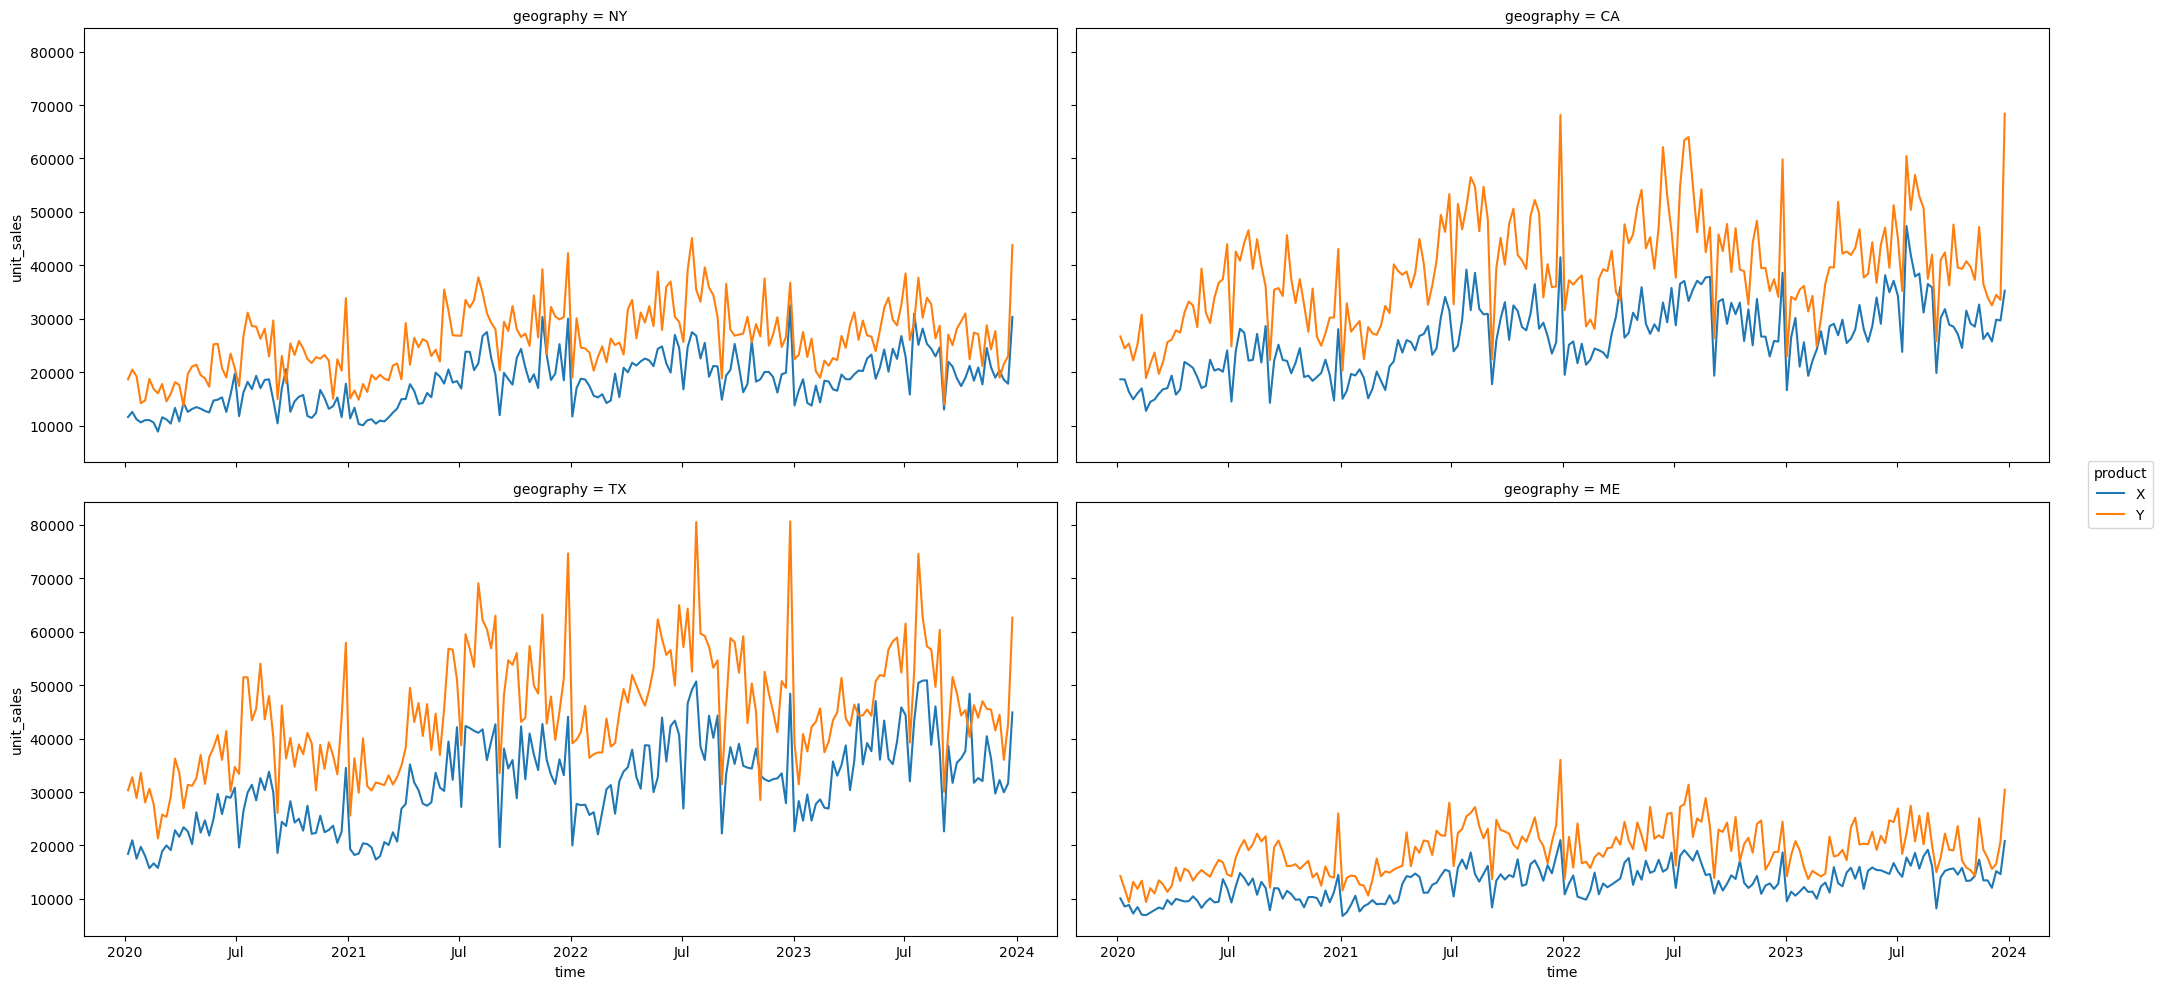

In [29]:
unit_sales.plot.line(x="time", col="geography", hue="product", col_wrap=2,aspect=2, size=5)

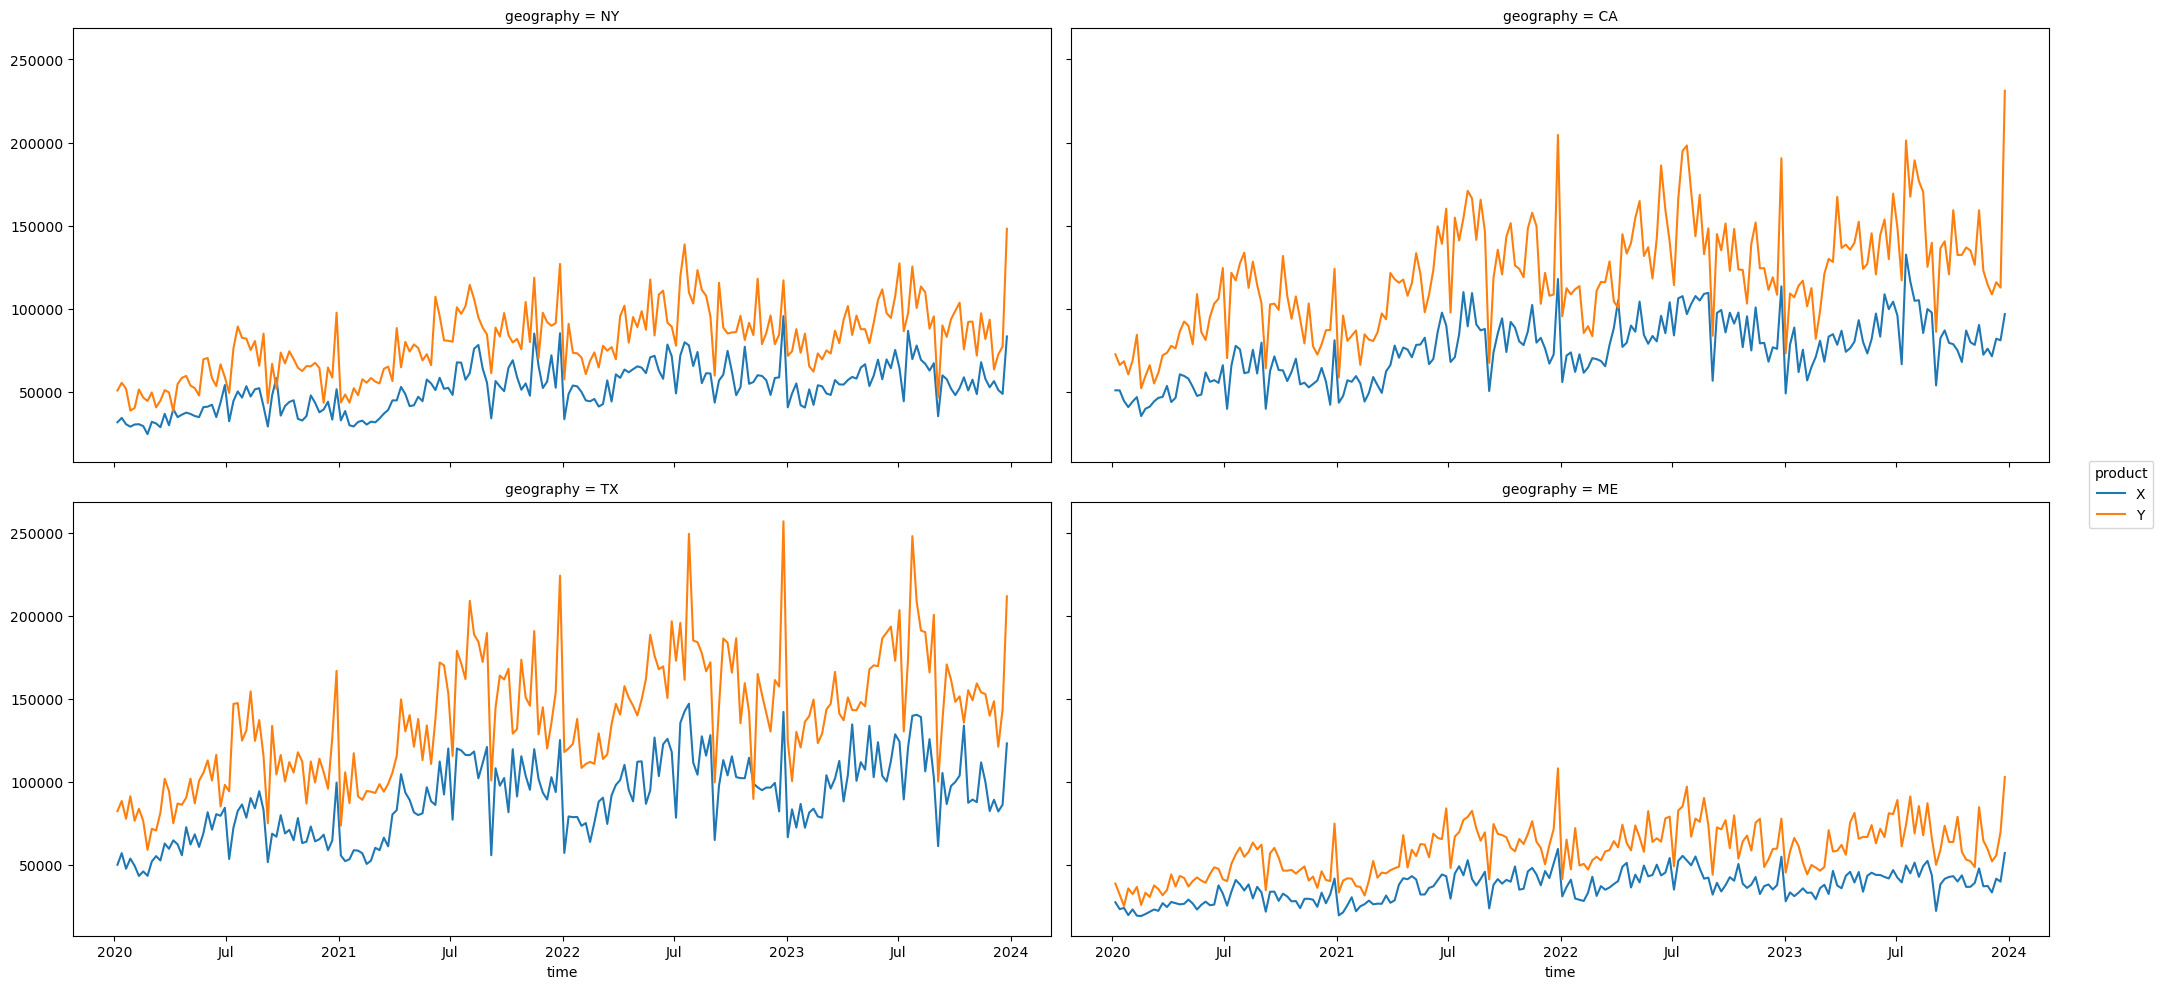

In [30]:
sales.plot.line(x="time", hue="product", col="geography", col_wrap=2, aspect=2, size=5)

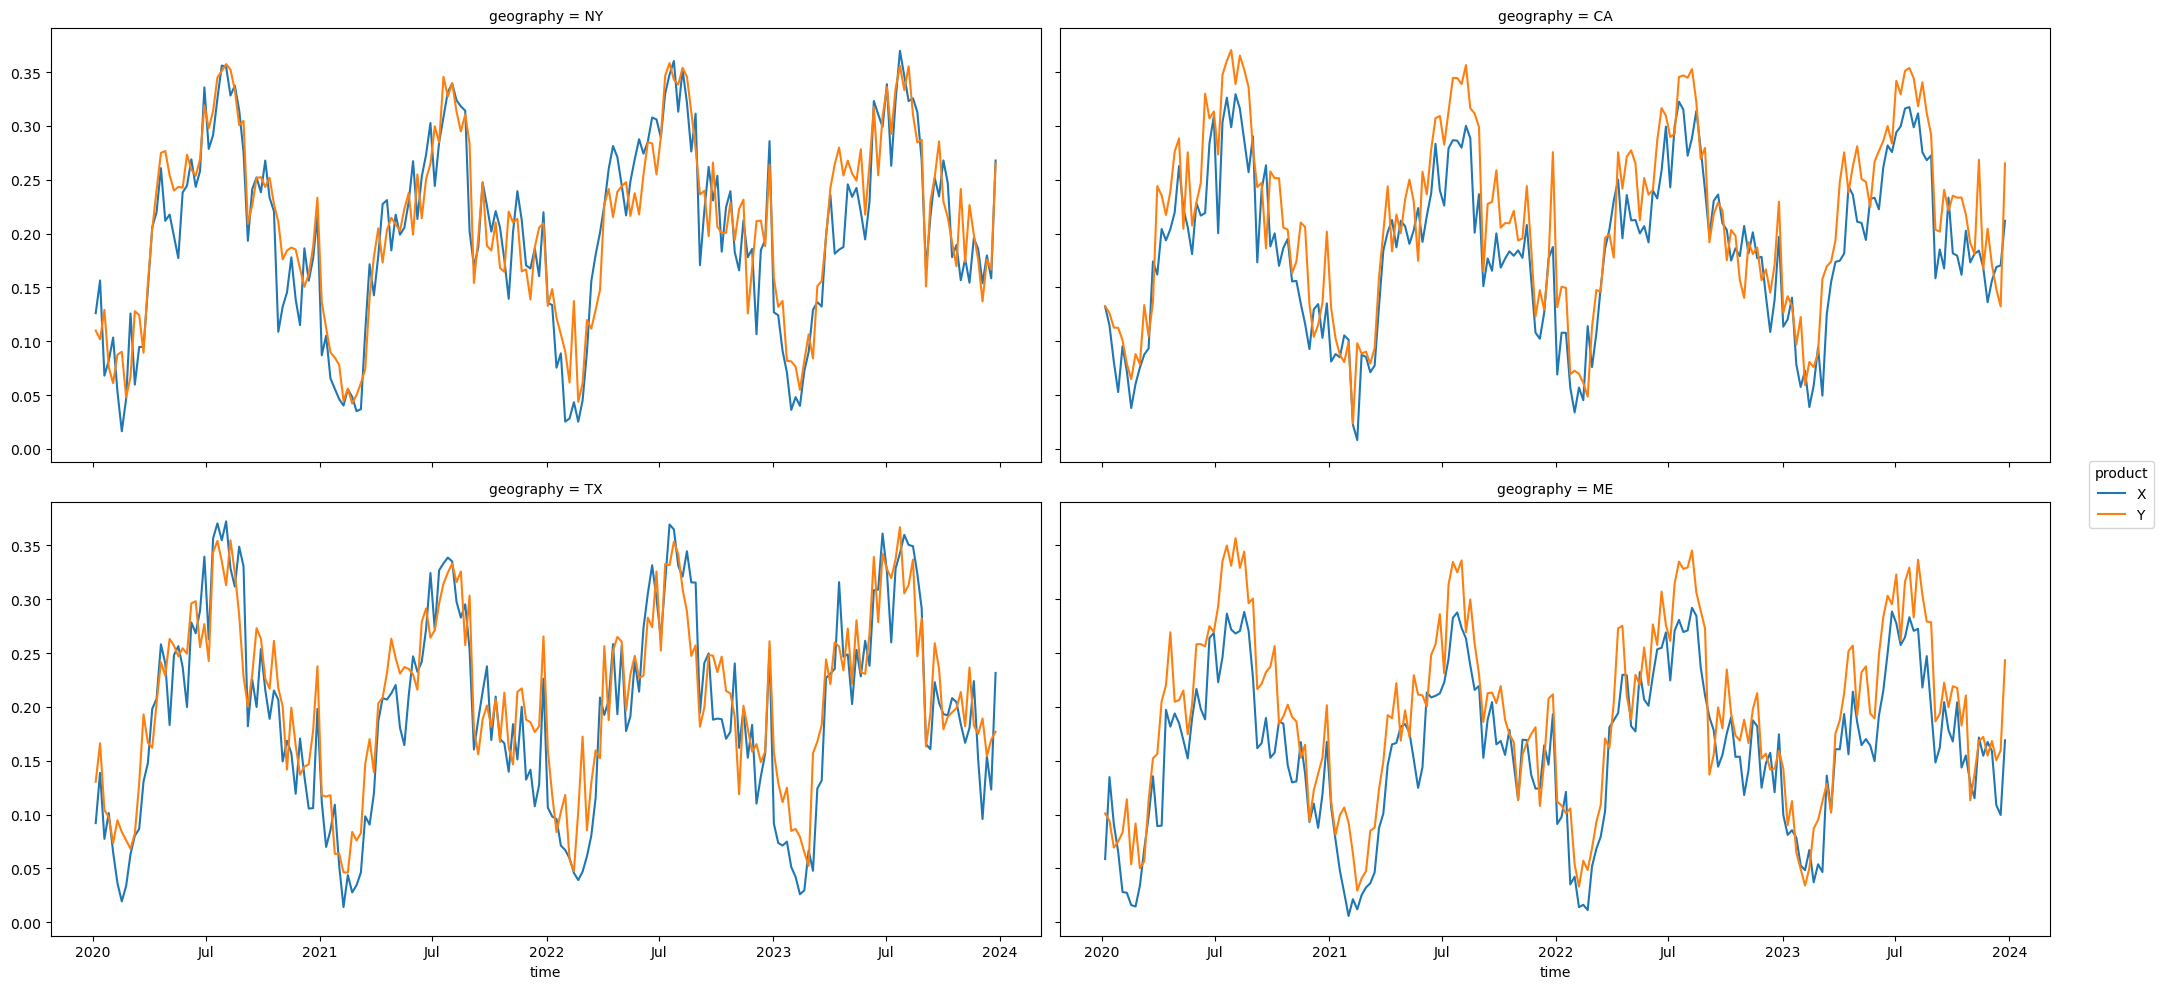

In [31]:
((unit_sales-base_effect)/unit_sales).plot.line(x='time', hue='product', col='geography', col_wrap=2, aspect=2, size=5)

In [32]:
social_mff = (
  social_impressions
  .to_dataframe("Social Impressions")
  .reset_index()
  .melt(
    id_vars=[
      "time", "geography", "product", 
      "campaign", 'social_outlet', 
      'social_creative'], 
    value_name='VariableValue',
    var_name='VariableName')
  .rename(columns={
    'time': "Period", 
    "geography": "Geography",
    'product': "Product",
    'campaign': "Campaign",
    'social_outlet': "Outlet",
    'social_creative': "Creative"
    })
)
social_mff.head()

Period Geography Product Campaign     Outlet Creative  \
0 2020-01-06        NY       X        A   Facebook    Image   
1 2020-01-06        NY       X        A   Facebook    Video   
2 2020-01-06        NY       X        A  Instagram    Image   
3 2020-01-06        NY       X        A  Instagram    Video   
4 2020-01-06        NY       X        A   Snapchat    Image   

         VariableName  VariableValue  
0  Social Impressions    8112.828434  
1  Social Impressions   26188.145257  
2  Social Impressions    9971.339030  
3  Social Impressions   14315.591781  
4  Social Impressions    7409.635488

In [33]:
display_mff = (
  display_impressions
  .to_dataframe("Display Impressions")
  .reset_index()
  .melt(
    id_vars=[
      "time", "geography", "product", 
      "campaign", 'display_outlet', 
      'display_creative'],
    value_name='VariableValue',
    var_name='VariableName'
    )
  .rename(columns={
    'time': "Period", 
    "geography": "Geography",
    'product': "Product",
    'campaign': "Campaign",
    'display_outlet': "Outlet",
    'display_creative': "Creative"
    })
)
display_mff.head()

Period Geography Product Campaign Outlet       Creative  \
0 2020-01-06        NY       X        A  Yahoo  Desktop-Large   
1 2020-01-06        NY       X        A  Yahoo         Mobile   
2 2020-01-06        NY       X        A  Yahoo  Desktop-Small   
3 2020-01-06        NY       X        A    DVM  Desktop-Large   
4 2020-01-06        NY       X        A    DVM         Mobile   

          VariableName  VariableValue  
0  Display Impressions   26962.661587  
1  Display Impressions   39059.067818  
2  Display Impressions   21986.146822  
3  Display Impressions    1526.605931  
4  Display Impressions       0.000000

In [34]:
olv_mff = (
  olv_impressions
  .to_dataframe("OLV Impressions")
  .reset_index()
  .melt(
    id_vars=[
      "time", "geography", "product", 
      "campaign", 'olv_outlet', 
      'olv_creative'], 
    value_name='VariableValue',
    var_name='VariableName')
  .rename(columns={
    'time': "Period", 
    "geography": "Geography",
    'product': "Product",
    'campaign': "Campaign",
    'olv_outlet': "Outlet",
    'olv_creative': "Creative"
    })
)
olv_mff.head()

Period Geography Product Campaign   Outlet Creative     VariableName  \
0 2020-01-06        NY       X        A  YouTube       15  OLV Impressions   
1 2020-01-06        NY       X        A  YouTube       30  OLV Impressions   
2 2020-01-06        NY       X        A    Prime       15  OLV Impressions   
3 2020-01-06        NY       X        A    Prime       30  OLV Impressions   
4 2020-01-06        NY       X        B  YouTube       15  OLV Impressions   

   VariableValue  
0    1223.215616  
1       0.000000  
2    2036.638018  
3    1210.705539  
4       0.000000

In [35]:
audio_mff = (
  audio_impressions
  .to_dataframe("Audio Impressions")
  .reset_index()
  .melt(
    id_vars=[
      "time", "geography", "product", 
      "campaign", 'audio_outlet', 
      'audio_creative'], 
    value_name='VariableValue',
    var_name='VariableName')
  .rename(columns={
    'time': "Period", 
    "geography": "Geography",
    'product': "Product",
    'campaign': "Campaign",
    'audio_outlet': "Outlet",
    'audio_creative': "Creative"
    })
)
audio_mff.head()

Period Geography Product Campaign   Outlet    Creative  \
0 2020-01-06        NY       X        A  Spotify  Streamming   
1 2020-01-06        NY       X        A  Spotify     Podcast   
2 2020-01-06        NY       X        A  Pandora  Streamming   
3 2020-01-06        NY       X        A  Pandora     Podcast   
4 2020-01-06        NY       X        B  Spotify  Streamming   

        VariableName  VariableValue  
0  Audio Impressions     915.277107  
1  Audio Impressions     893.359337  
2  Audio Impressions       0.000000  
3  Audio Impressions     284.266446  
4  Audio Impressions       0.000000

In [36]:
sales_mff = (
  sales
  .to_dataframe("Sales")
  .reset_index()
  .melt(
    id_vars=["time", "geography", "product"],
    value_name="VariableValue",
    var_name="VariableName")
  .rename(columns={
    "time": "Period",
    "geography": "Geography",
    "product": "Product"
    })
  .assign(
    Campaign="Total",
    Outlet="Total",
    Creative="Total"
    )
)
sales_mff.head()

Period Geography Product VariableName  VariableValue Campaign Outlet  \
0 2020-01-06        NY       X        Sales   31560.856351    Total  Total   
1 2020-01-06        CA       X        Sales   50783.763321    Total  Total   
2 2020-01-06        TX       X        Sales   50097.884859    Total  Total   
3 2020-01-06        ME       X        Sales   27490.394332    Total  Total   
4 2020-01-06        NY       Y        Sales   50656.417627    Total  Total   

  Creative  
0    Total  
1    Total  
2    Total  
3    Total  
4    Total

In [37]:
unit_sales_mff = (
  unit_sales.to_dataframe("Unit Sales")
  .reset_index()
  .melt(
    id_vars=["time", "geography", "product"],
    value_name="VariableValue",
    var_name="VariableName")
  .rename(columns={
    "time":"Period", 
    "geography":"Geography",
    "product":"Product"
    })
  .assign(
    Campaign="Total",
    Outlet="Total",
    Creative="Total"
    )
)
unit_sales_mff.head()

Period Geography Product VariableName  VariableValue Campaign Outlet  \
0 2020-01-06        NY       X   Unit Sales   11604.527527    Total  Total   
1 2020-01-13        NY       X   Unit Sales   12558.601295    Total  Total   
2 2020-01-20        NY       X   Unit Sales   11168.736637    Total  Total   
3 2020-01-27        NY       X   Unit Sales   10602.656921    Total  Total   
4 2020-02-03        NY       X   Unit Sales   11020.136036    Total  Total   

  Creative  
0    Total  
1    Total  
2    Total  
3    Total  
4    Total

In [38]:
price_mff = (
  pd.concat([price
  .to_dataframe("Price")
  .reset_index()
  .melt(
    id_vars=["time", "product"],
    value_name="VariableValue",
    var_name="VariableName")
  .rename(columns={
    "time":"Period",
    "product":"Product"
    })
  .assign(
    Geography=geo,
    Campaign="Total",
    Outlet="Total",
    Creative="Total"
    ) for geo in geographies])
)
price_mff.head()

Period Product VariableName  VariableValue Geography Campaign Outlet  \
0 2020-01-06       X        Price       2.719702        NY    Total  Total   
1 2020-01-06       Y        Price       2.716049        NY    Total  Total   
2 2020-01-13       X        Price       2.721923        NY    Total  Total   
3 2020-01-13       Y        Price       2.700855        NY    Total  Total   
4 2020-01-20       X        Price       2.719586        NY    Total  Total   

  Creative  
0    Total  
1    Total  
2    Total  
3    Total  
4    Total

In [39]:
holiday_mff = pd.concat([
  holidays
  .reset_index().rename(columns={"index": "Period"})
  .melt(id_vars="Period", var_name="VariableName", value_name="VariableValue")
  .assign(
    Geography=geo,
    Product=prod,
    Campaign="Total",
    Outlet="Total",
    Creative="Total"
    )
  for geo, prod in product(geographies, products)]
  )
holiday_mff.head()


Period                                 VariableName  VariableValue  \
0 2020-01-06  Holiday_Birthday of Martin Luther King, Jr.            0.0   
1 2020-01-13  Holiday_Birthday of Martin Luther King, Jr.            0.0   
2 2020-01-20  Holiday_Birthday of Martin Luther King, Jr.            1.0   
3 2020-01-27  Holiday_Birthday of Martin Luther King, Jr.            0.0   
4 2020-02-03  Holiday_Birthday of Martin Luther King, Jr.            0.0   

  Geography Product Campaign Outlet Creative  
0        NY       X    Total  Total    Total  
1        NY       X    Total  Total    Total  
2        NY       X    Total  Total    Total  
3        NY       X    Total  Total    Total  
4        NY       X    Total  Total    Total

In [40]:
fake_mff = pd.concat([
  olv_mff,
  social_mff,
  display_mff,
  audio_mff,
  price_mff,
  unit_sales_mff,
  sales_mff,
  holiday_mff
])

In [41]:
fake_mff.to_csv('fake_mff.csv',index=False)

In [42]:
pivoted_data = fake_mff.pivot(index=("Period", "Geography", "Product"), columns=["VariableName", "Campaign", "Outlet", "Creative"], values="VariableValue")

In [43]:
np.corrcoef(pivoted_data['OLV Impressions'].sum(axis=1), pivoted_data["Social Impressions"].sum(axis=1))


array([[1.        , 0.79512272],
       [0.79512272, 1.        ]])

In [44]:
np.corrcoef(social_impressions.sum(dim=("campaign", "social_outlet", "social_creative")).sel(geography="NY", product='X'), audio_impressions.sum(dim=("campaign", "audio_outlet", "audio_creative")).sel(geography="NY", product='X'))

array([[1.        , 0.82436833],
       [0.82436833, 1.        ]])

In [45]:
import pymc as pm

In [46]:
fourier_data.shape

(10, 208)

In [47]:
splines.shape

(208, 17)

In [102]:
with pm.Model(coords={"geos": geographies, 'product': products, 'period': date}) as simple:
  alpha = pm.Normal("alpha", mu=0, tau=1, dims=("geos", "product"))
  
  beta_a_mu = pm.Normal("beta_audio_mu", mu=0, tau=1)
  beta_a_sd = pm.HalfCauchy("beta_audio_sd", beta=1)
  beta_a = pm.Normal("beta_audio", mu=beta_a_mu, tau=beta_a_sd, dims=("geos", "product"))
  beta_o_mu = pm.Normal("beta_olv_mu", mu=0, tau=1)
  beta_o_sd = pm.HalfCauchy("beta_olv_sd", beta=1)
  beta_o = pm.Normal("beta_olv", mu=beta_o_mu, tau=beta_o_sd, dims=("geos", "product"))
  beta_s_mu = pm.Normal("beta_social_mu", mu=0, tau=1)
  beta_s_sd = pm.HalfCauchy("beta_social_sd", beta=1)
  beta_s = pm.Normal("beta_social", mu=beta_s_mu, tau=beta_s_sd, dims=("geos", "product"))
  beta_d_mu = pm.Normal("beta_display_mu", mu=0, tau=1)
  beta_d_sd = pm.HalfCauchy('beta_display_sd', beta=1)
  beta_d = pm.Normal("beta_display", mu=beta_d_mu, tau=beta_d_sd, dims=("geos", "product"))
  beta_holiday = pm.Normal("beta_holiday", mu=0, tau=1)
  beta_season = pm.Normal("beta_season", mu=0, tau=1)
  beta_trend = pm.Normal("beta_trend", mu=0, tau=1)
  beta_price = pm.Normal("beta_price", mu=0, tau=1)
  sigma = pm.HalfCauchy("sigma", beta=1)
  mu = pm.Deterministic("mu", 
        alpha[None, :, :] + beta_a[None, ...]*adstock_hill_audio.values 
        + beta_o[None, ...]*adstock_hill_olv.values + beta_s[None, ...]*adstock_hill_social.values
        + beta_d[None, ...]*adstock_hill_display.values
        + beta_season*season_xr.values[:, None, None]
        + beta_trend*trend_xr.values[:, None, None]
        + beta_price*price.values[:, None, :] + beta_holiday*holiday_effect_xr.values[:, None, None],
        dims=("period", "geos", "product"))
  y = pm.LogNormal("y", mu=mu, tau=sigma, observed=unit_sales.transpose("time", "geography", "product").values, dims=("period", "geos", "product"))
  trace = pm.sample(1000, tune=1000, nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 37 divergences after tuning. Increase `target_accept` or reparameterize.


In [151]:
pm.draw(pm.DiracDelta.dist(0.0))

array(0.)

In [153]:
with pm.Model(coords={"geos": geographies, 'product': products, 'period': date}) as simple:
  alpha = pm.Normal("alpha", mu=0, tau=1, dims=("geos", "product"))
  
  beta_a_mu = pm.Normal("beta_audio_mu", mu=0, tau=1)
  beta_a_sd = pm.HalfCauchy("beta_audio_sd", beta=1)
  beta_a = pm.Normal("beta_audio", mu=beta_a_mu, tau=beta_a_sd, dims=("geos", "product"))
  beta_o_mu = pm.Normal("beta_olv_mu", mu=0, tau=1)
  beta_o_sd = pm.HalfCauchy("beta_olv_sd", beta=1)
  beta_o = pm.Normal("beta_olv", mu=beta_o_mu, tau=beta_o_sd, dims=("geos", "product"))
  beta_s_mu = pm.Normal("beta_social_mu", mu=0, tau=1)
  beta_s_sd = pm.HalfCauchy("beta_social_sd", beta=1)
  beta_s = pm.Normal("beta_social", mu=beta_s_mu, tau=beta_s_sd, dims=("geos", "product"))
  beta_d_mu = pm.Normal("beta_display_mu", mu=0, tau=1)
  beta_d_sd = pm.HalfCauchy('beta_display_sd', beta=1)
  beta_d = pm.Normal("beta_display", mu=beta_d_mu, tau=beta_d_sd, dims=("geos", "product"))
  beta_holiday = pm.Normal("beta_holiday", mu=0, tau=1)
  beta_season = pm.Normal("beta_season", mu=0, tau=1, shape=fourier_data.shape[0])
  
  beta_trend = pm.Normal(
    "beta_trend", mu=0, sigma=.2, 
    shape=splines.shape[1]
    )
  beta_price = pm.Normal("beta_price", mu=0, tau=1)
  sigma = pm.HalfCauchy("sigma", beta=1)
  mu = pm.Deterministic("mu", 
        alpha[None, :, :] + beta_a[None, ...]*adstock_hill_audio.values 
        + beta_o[None, ...]*adstock_hill_olv.values + beta_s[None, ...]*adstock_hill_social.values
        + beta_d[None, ...]*adstock_hill_display.values
        + (beta_season @ fourier_data)[:, None, None]
        + (splines @ beta_trend)[:, None, None]
        + beta_price*price.values[:, None, :] 
        + beta_holiday*holiday_effect_xr.values[:, None, None],
        dims=("period", "geos", "product"))
  y = pm.LogNormal("y", mu=mu, tau=sigma, observed=unit_sales.transpose("time", "geography", "product").values, dims=("period", "geos", "product"))
  trace = pm.sample(1000, tune=1000, nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [154]:
pm.summary(
  trace, 
  var_names=[
    "alpha", "beta_audio_mu", "beta_olv_mu", 
    "beta_display_mu", "beta_social_mu", 
    #"beta_holiday", #"beta_season", 
    #"beta_trend", 
    "sigma"
  ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[NY, X]      9.196  0.091   9.030    9.376      0.003    0.002    1090.0   
alpha[NY, Y]      9.572  0.089   9.409    9.745      0.003    0.002    1147.0   
alpha[CA, X]      9.562  0.091   9.402    9.744      0.003    0.002    1123.0   
alpha[CA, Y]      9.998  0.087   9.839   10.173      0.003    0.002    1081.0   
alpha[TX, X]      9.706  0.092   9.529    9.882      0.003    0.002    1152.0   
alpha[TX, Y]     10.133  0.088   9.971   10.307      0.003    0.002    1131.0   
alpha[ME, X]      8.835  0.090   8.669    9.011      0.003    0.002    1141.0   
alpha[ME, Y]      9.301  0.088   9.147    9.485      0.003    0.002    1127.0   
beta_audio_mu     0.115  0.038   0.044    0.182      0.001    0.001    1583.0   
beta_olv_mu       0.221  0.040   0.144    0.297      0.001    0.001    2537.0   
beta_display_mu   0.049  0.033  -0.011    0.107      0.001    0.001    3149.0   
beta_social_mu    0.127  0.033   0.068    0.189      0.001    0.001    1256.0   
sigma            97.076  3.539  90.197  103.412      0.051    0.036    4775.0   

                 ess_tail  r_hat  
alpha[NY, X]       1789.0    1.0  
alpha[NY, Y]       1787.0    1.0  
alpha[CA, X]       1758.0    1.0  
alpha[CA, Y]       1800.0    1.0  
alpha[TX, X]       1787.0    1.0  
alpha[TX, Y]       1676.0    1.0  
alpha[ME, X]       1790.0    1.0  
alpha[ME, Y]       1723.0    1.0  
beta_audio_mu      2119.0    1.0  
beta_olv_mu        2196.0    1.0  
beta_display_mu    2128.0    1.0  
beta_social_mu     2089.0    1.0  
sigma              2590.0    1.0

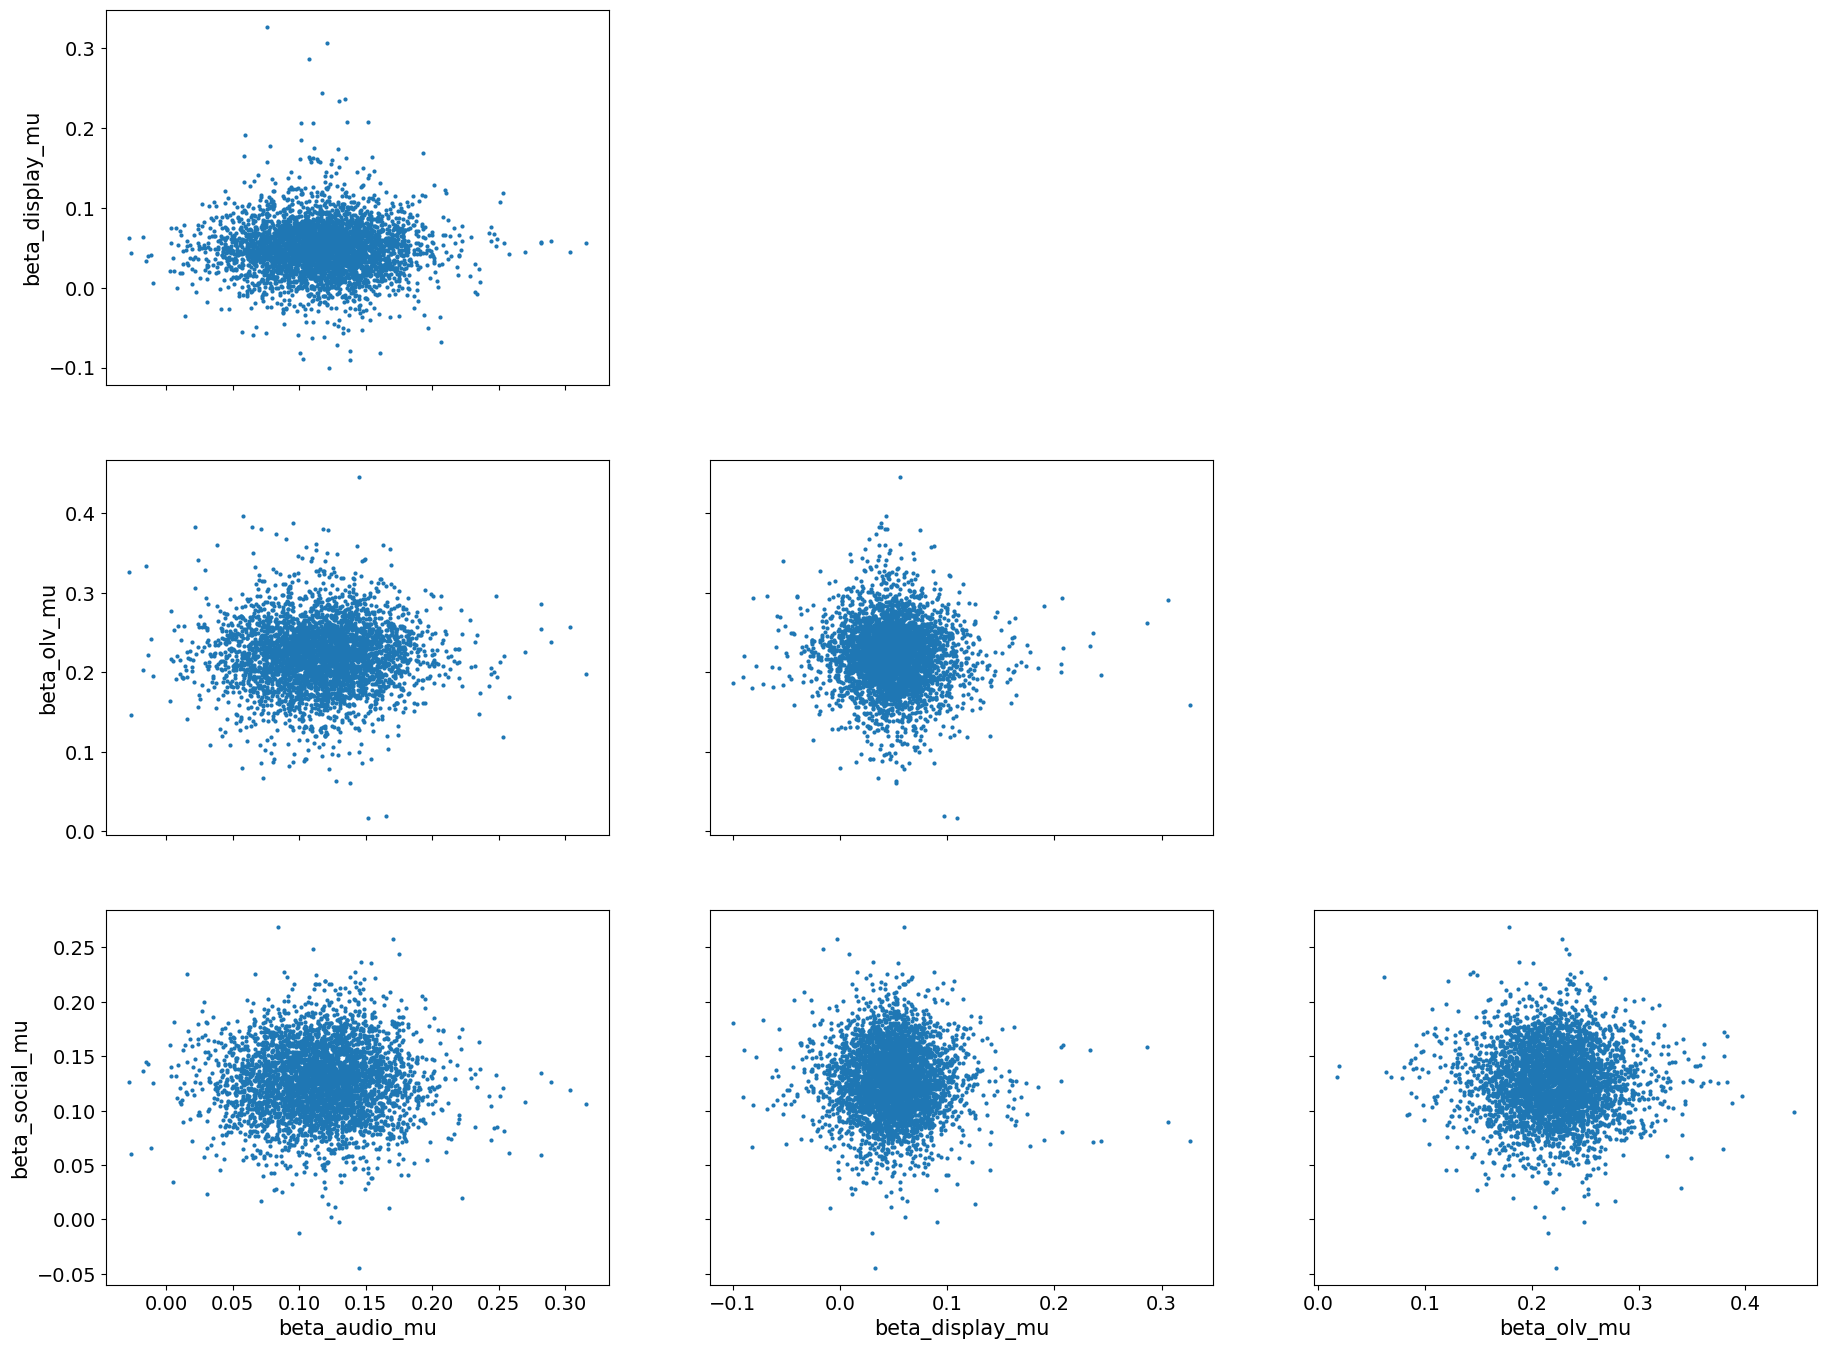

In [155]:
pm.plot_pair(
  trace, 
  var_names=[
    "beta_audio_mu", "beta_display_mu", 
    "beta_olv_mu", "beta_social_mu", 
    #"beta_holiday", "beta_season", 
    #"beta_trend", "sigma"
  ]
);

In [156]:
pm.summary(
  trace, 
  var_names=[
    "alpha", "beta_audio", 
    "beta_olv", "beta_display", 
    "beta_social",# "beta_season", 
    #"beta_trend", "sigma"
  ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha[NY, X]          9.196  0.091   9.030    9.376      0.003    0.002   
alpha[NY, Y]          9.572  0.089   9.409    9.745      0.003    0.002   
alpha[CA, X]          9.562  0.091   9.402    9.744      0.003    0.002   
alpha[CA, Y]          9.998  0.087   9.839   10.173      0.003    0.002   
alpha[TX, X]          9.706  0.092   9.529    9.882      0.003    0.002   
alpha[TX, Y]         10.133  0.088   9.971   10.307      0.003    0.002   
alpha[ME, X]          8.835  0.090   8.669    9.011      0.003    0.002   
alpha[ME, Y]          9.301  0.088   9.147    9.485      0.003    0.002   
beta_audio[NY, X]     0.114  0.041   0.032    0.189      0.001    0.001   
beta_audio[NY, Y]     0.115  0.043   0.029    0.194      0.001    0.001   
beta_audio[CA, X]     0.108  0.041   0.030    0.181      0.001    0.001   
beta_audio[CA, Y]     0.056  0.049  -0.035    0.148      0.001    0.001   
beta_audio[TX, X]     0.128  0.042   0.051    0.209      0.001    0.001   
beta_audio[TX, Y]     0.123  0.041   0.046    0.202      0.001    0.001   
beta_audio[ME, X]     0.173  0.046   0.093    0.263      0.001    0.001   
beta_audio[ME, Y]     0.109  0.042   0.030    0.189      0.001    0.001   
beta_olv[NY, X]       0.154  0.051   0.056    0.248      0.001    0.001   
beta_olv[NY, Y]       0.198  0.047   0.110    0.285      0.001    0.001   
beta_olv[CA, X]       0.198  0.050   0.103    0.293      0.001    0.001   
beta_olv[CA, Y]       0.271  0.054   0.176    0.376      0.001    0.001   
beta_olv[TX, X]       0.240  0.048   0.148    0.330      0.001    0.001   
beta_olv[TX, Y]       0.227  0.048   0.138    0.321      0.001    0.001   
beta_olv[ME, X]       0.270  0.048   0.184    0.359      0.001    0.001   
beta_olv[ME, Y]       0.212  0.048   0.129    0.309      0.001    0.001   
beta_display[NY, X]   0.005  0.032  -0.057    0.065      0.001    0.000   
beta_display[NY, Y]   0.047  0.033  -0.016    0.108      0.001    0.000   
beta_display[CA, X]   0.072  0.033   0.011    0.134      0.001    0.000   
beta_display[CA, Y]   0.018  0.037  -0.058    0.081      0.001    0.001   
beta_display[TX, X]   0.123  0.036   0.055    0.191      0.001    0.000   
beta_display[TX, Y]  -0.002  0.036  -0.064    0.069      0.001    0.001   
beta_display[ME, X]   0.076  0.033   0.017    0.141      0.001    0.000   
beta_display[ME, Y]   0.049  0.033  -0.013    0.111      0.000    0.000   
beta_social[NY, X]    0.120  0.037   0.052    0.188      0.001    0.001   
beta_social[NY, Y]    0.119  0.039   0.047    0.195      0.001    0.001   
beta_social[CA, X]    0.127  0.036   0.059    0.196      0.001    0.001   
beta_social[CA, Y]    0.132  0.042   0.051    0.207      0.001    0.001   
beta_social[TX, X]    0.151  0.041   0.077    0.230      0.001    0.001   
beta_social[TX, Y]    0.128  0.040   0.054    0.203      0.001    0.001   
beta_social[ME, X]    0.128  0.037   0.057    0.194      0.001    0.001   
beta_social[ME, Y]    0.114  0.039   0.036    0.182      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
alpha[NY, X]           1090.0    1789.0    1.0  
alpha[NY, Y]           1147.0    1787.0    1.0  
alpha[CA, X]           1123.0    1758.0    1.0  
alpha[CA, Y]           1081.0    1800.0    1.0  
alpha[TX, X]           1152.0    1787.0    1.0  
alpha[TX, Y]           1131.0    1676.0    1.0  
alpha[ME, X]           1141.0    1790.0    1.0  
alpha[ME, Y]           1127.0    1723.0    1.0  
beta_audio[NY, X]      2088.0    2755.0    1.0  
beta_audio[NY, Y]      2061.0    2462.0    1.0  
beta_audio[CA, X]      2437.0    2753.0    1.0  
beta_audio[CA, Y]      1730.0    2435.0    1.0  
beta_audio[TX, X]      2319.0    2825.0    1.0  
beta_audio[TX, Y]      2083.0    2825.0    1.0  
beta_audio[ME, X]      1680.0    2207.0    1.0  
beta_audio[ME, Y]      2239.0    2897.0    1.0  
beta_olv[NY, X]        2147.0    2577.0    1.0  
beta_olv[NY, Y]        3087.0    3074.0    1.0  
beta_olv[CA, X] 

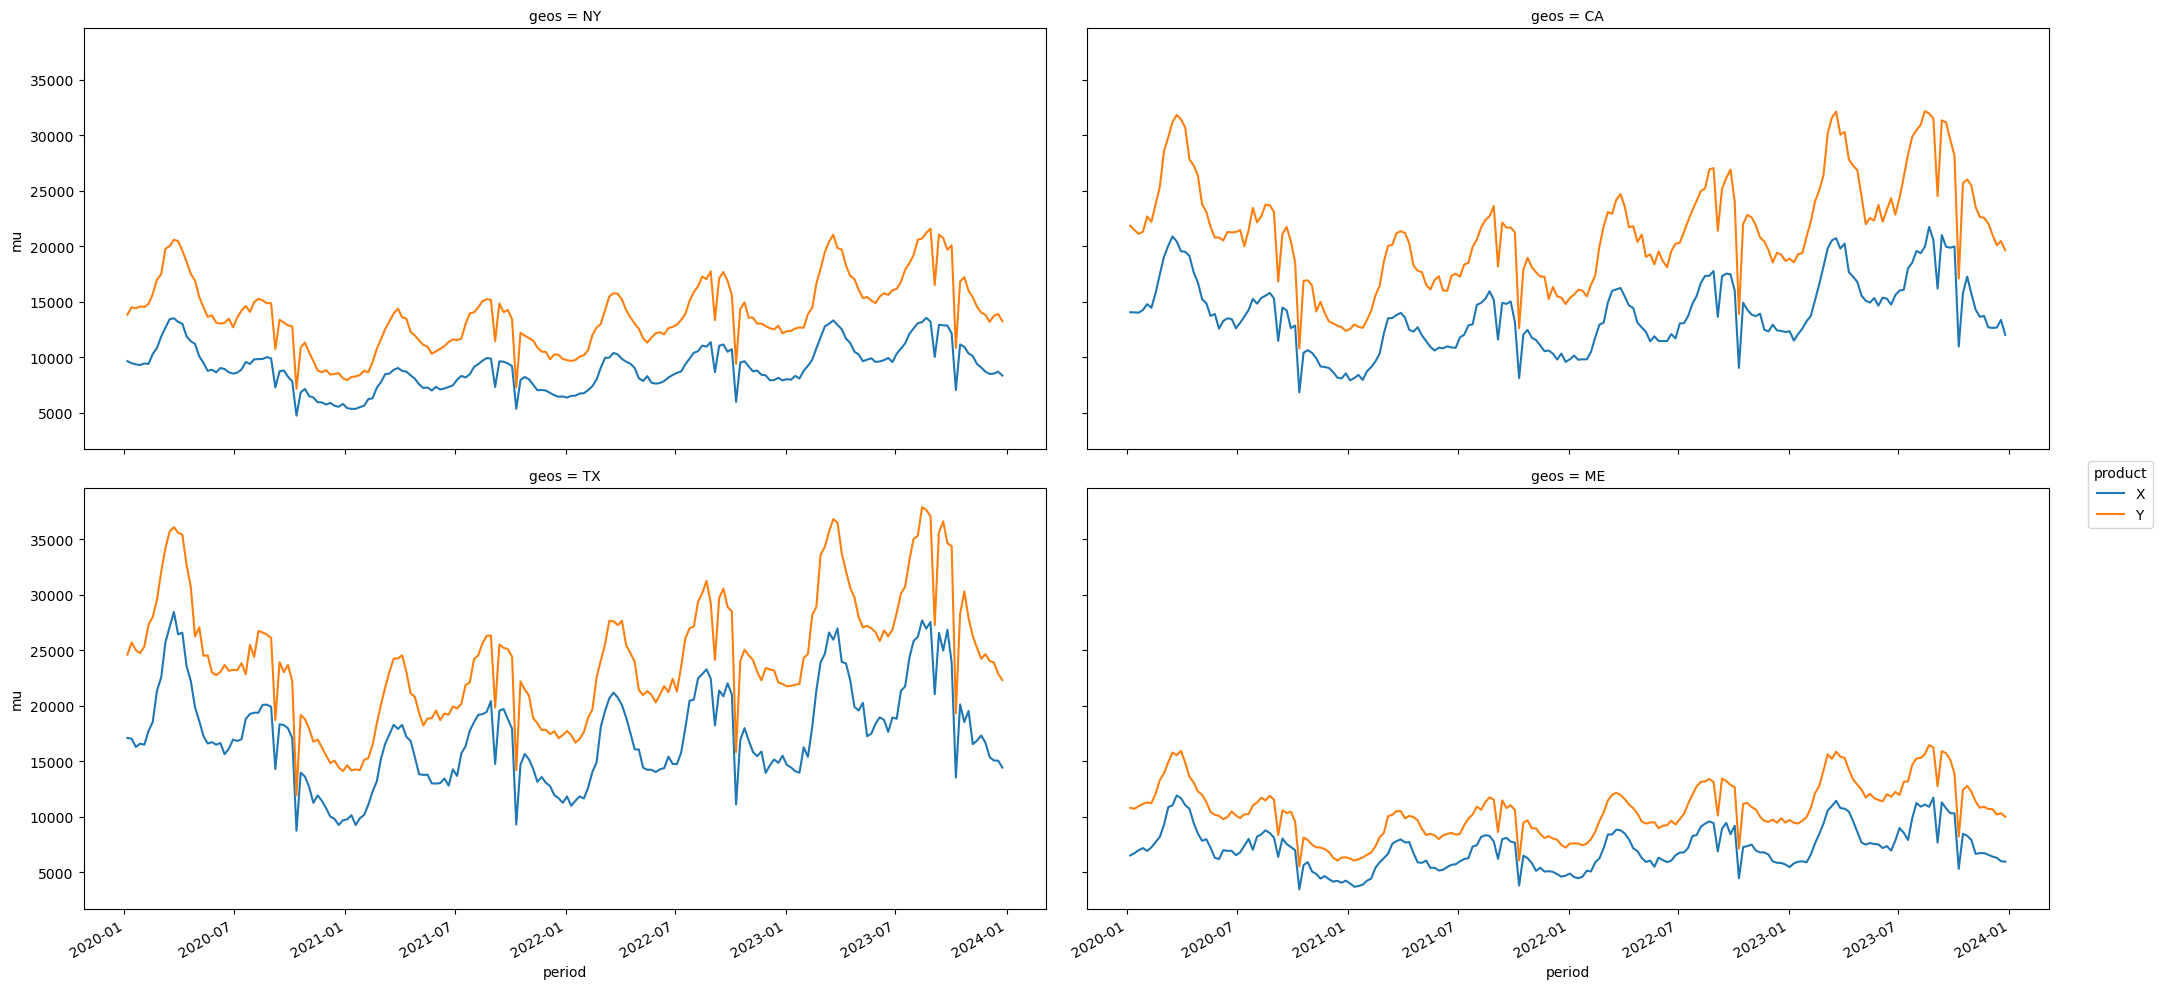

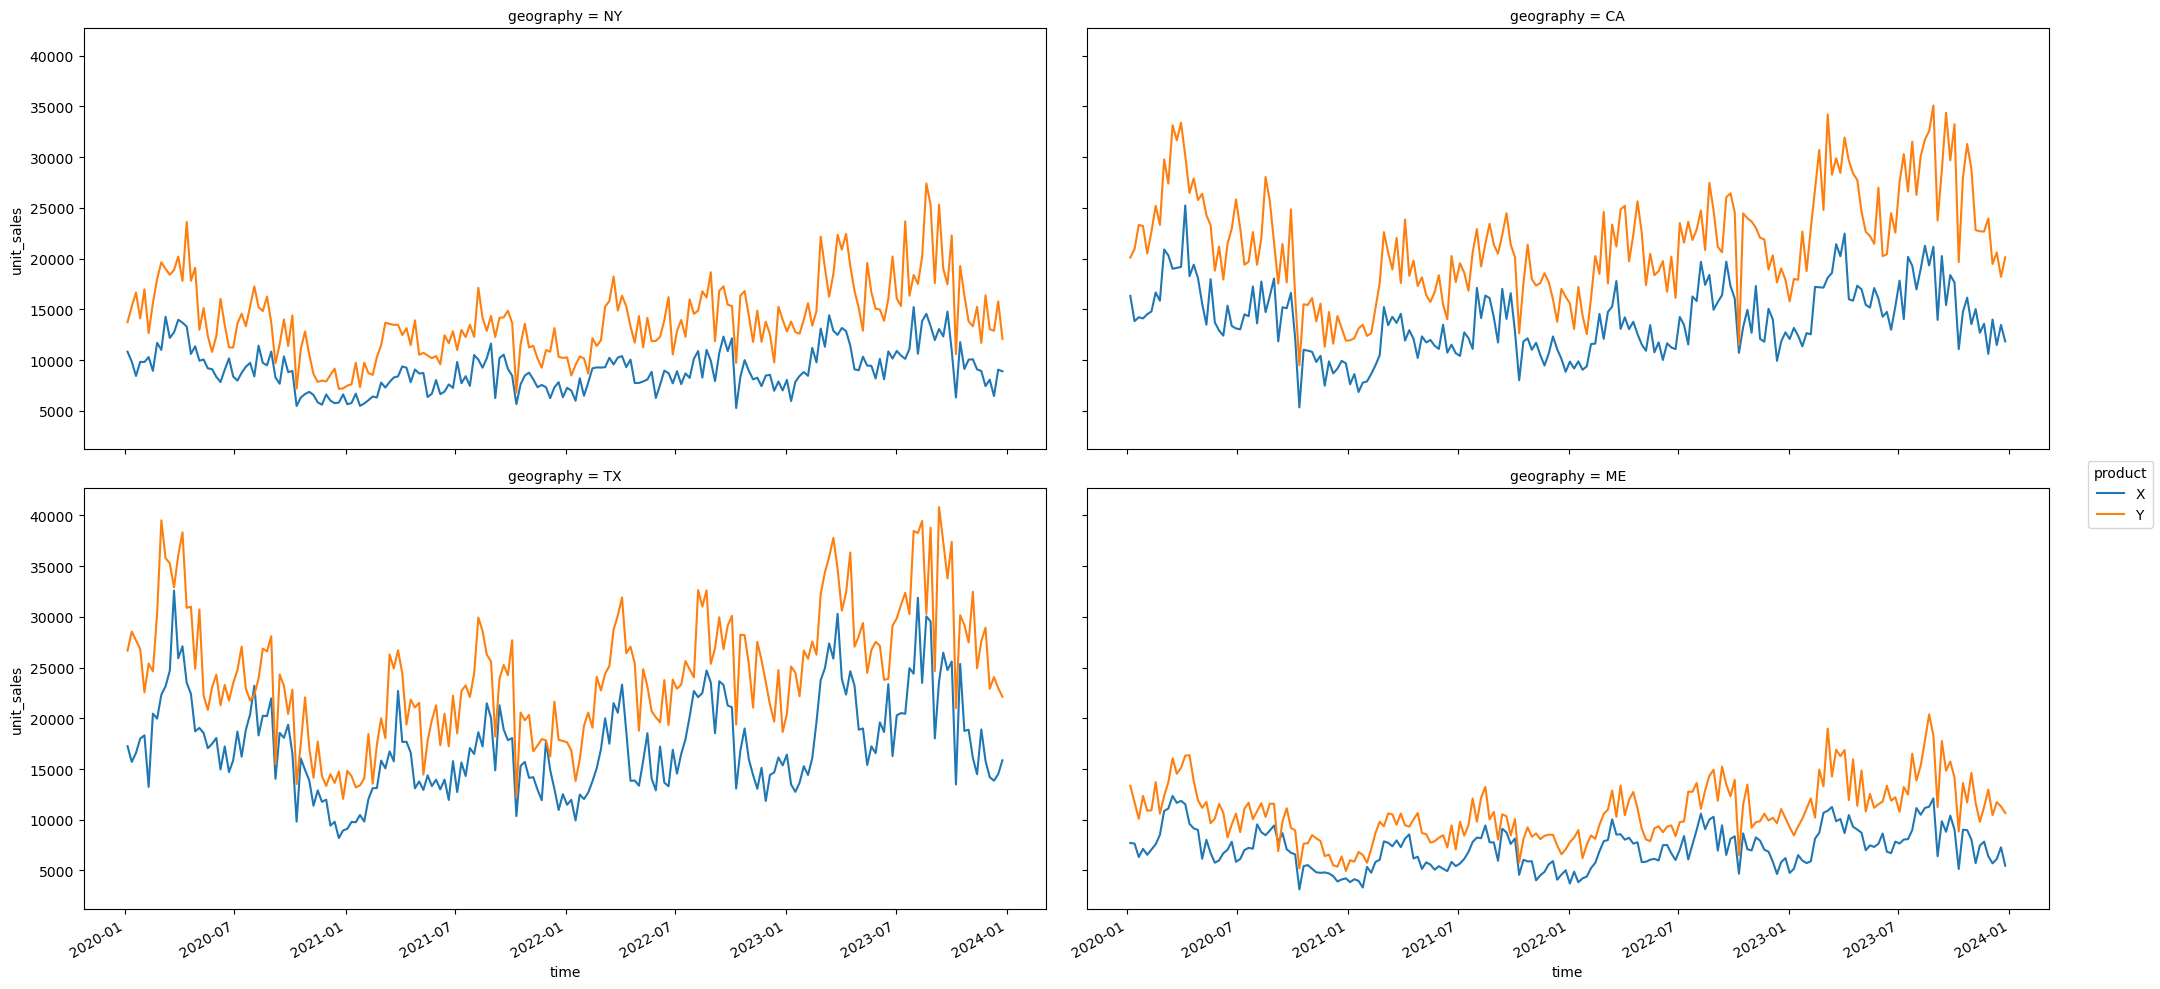

In [157]:
np.exp(trace.posterior["mu"]).mean(dim=("chain", 'draw')).plot.line(x="period", col="geos", hue="product", col_wrap=2, aspect=2, size=5)
unit_sales.plot.line(x="time", col='geography', hue='product', col_wrap=2, aspect=2, size=5)

In [158]:
mean_unit_sales = np.exp(trace.posterior["mu"]).mean(dim=("chain", 'draw')).rename({"geos": "geography", "period": "time"})
((unit_sales - mean_unit_sales)**2).mean()

<xarray.DataArray ()>
array(2469572.07132855)

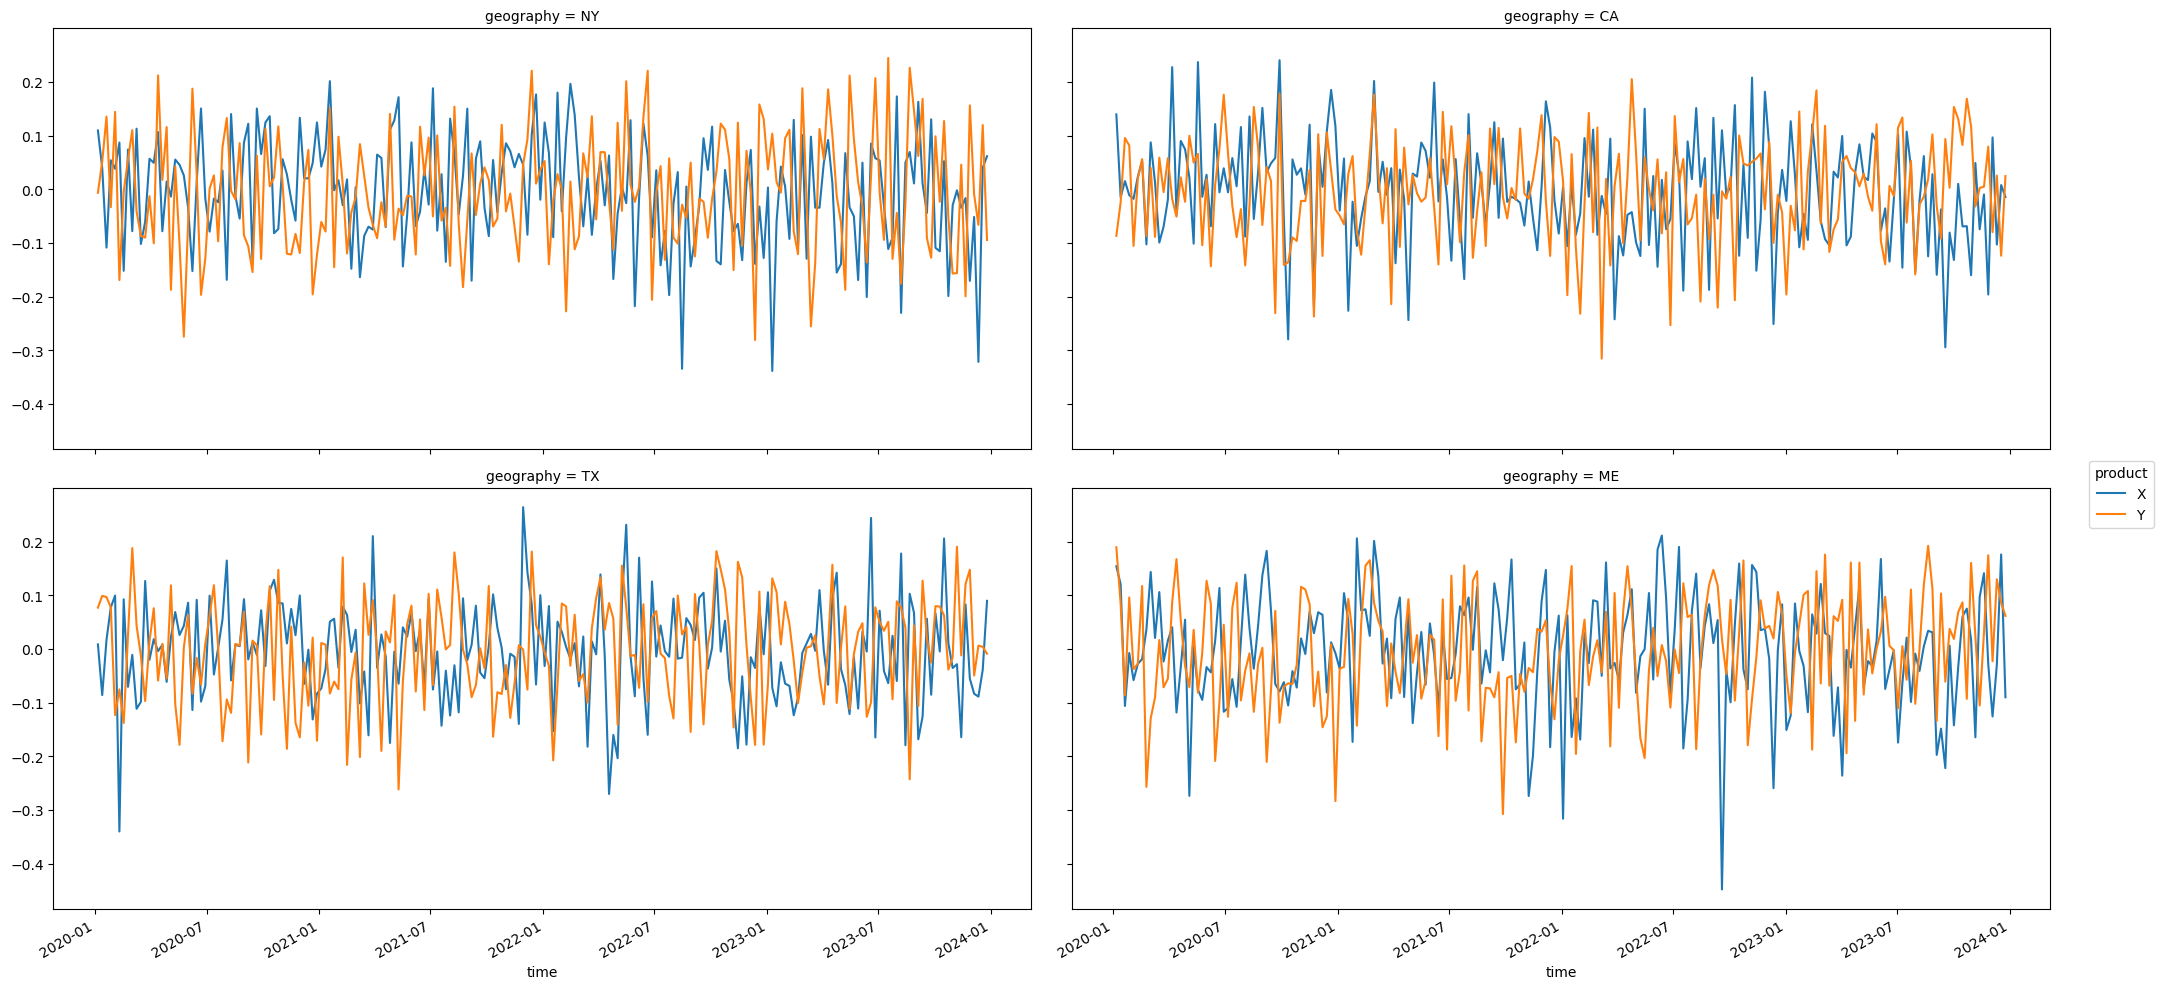

In [159]:
((unit_sales - mean_unit_sales)/unit_sales).plot.line(x="time", col="geography", hue="product", col_wrap=2, aspect=2, size=5)

In [160]:
from sklearn.metrics import r2_score

In [161]:
mean_unit_sales.shape

(208, 4, 2)

In [162]:
r2_score(unit_sales.transpose('time', 'geography', 'product').values.ravel(), mean_unit_sales.values.ravel())

0.9485095570755571

In [47]:
def s_curve(x, beta, alpha, index_to=1):
  return beta**(alpha**(100*x))

2.479046450312636
2.368333612617948


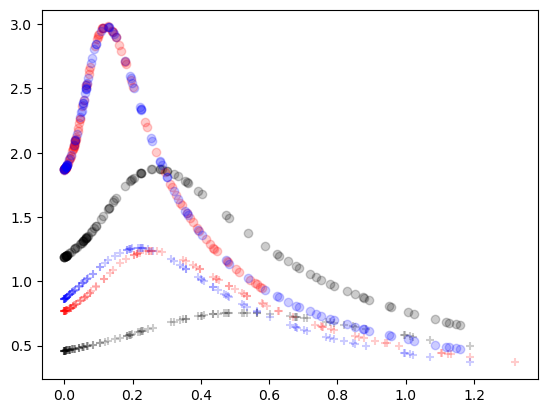

In [48]:
x = np.random.beta(0.4, 1, 100)*1.2
y = np.random.beta(0.4, 1, 100)*1.2
s_x0 = s_curve((2*x)/np.sqrt(5), 1e-4, .9, 2)
s_y0 = s_curve((y)/np.sqrt(5), 1e-4, .9, 2)
s_xy = s_curve((2*x[None, :] + y[:, None])/(np.sqrt(5)), 1e-4, .9, 2)

plt.scatter(x, (s_xy.mean(axis=0)-s_y0.mean())/x, c='k', alpha=.2)
plt.scatter(y, (s_xy.mean(axis=1)-s_x0.mean())/y, c='k', marker='+', alpha=.2)
print(np.max((s_xy.mean(axis=0)-s_xy.mean(axis=0).min())/x)/np.max((s_xy.mean(axis=1)-s_xy.mean(axis=1).min())/y))
s_x0 = s_curve(2*x, 1e-4, .9, 2)
s_y0 = s_curve(y, 1e-4, .9, 2)
s_xy =  s_curve((2*x[None, :] + y[:, None]), 1e-4, .9, 2)
s_0_x0 = s_curve(x, 1e-4, .9, 2)
s_0_y0 = s_curve(y, 1e-4, .9, 2)
s_0_xy = s_curve((x[None, :] + y[:, None]), 1e-4, .9, 2)
plt.scatter(x/2, 2*(s_0_xy.mean(axis=0)-s_0_y0.mean())/x, c='r', alpha=.2)
plt.scatter(y/.9, .76*(s_0_xy.mean(axis=1)-s_0_x0.mean())/y, c='r', marker='+', alpha=.2)
plt.scatter(x, (s_xy.mean(axis=0)-s_y0.mean())/x, c='b', alpha=.2)
plt.scatter(y, (s_xy.mean(axis=1)-s_x0.mean())/y, c='b', marker='+', alpha=.2)
print(np.max((s_xy.mean(axis=0)-s_xy.mean(axis=0).min())/x)/np.max((s_xy.mean(axis=1)-s_xy.mean(axis=1).min())/y))

In [49]:
np.max((s_xy.mean(axis=0)-s_xy.mean(axis=0).min())/x)/np.max((s_xy.mean(axis=1)-s_xy.mean(axis=1).min())/y)

2.368333612617948

In [50]:
max_for_weights = []
w_x = np.linspace(.1, .9, 100)
w_y = 1 - w_x

s_xy = lambda a, b: s_curve(2*w_x[:, None, None]*x[None, :, None] + 2*w_y[:, None, None]*y[None, None, :], 10**(-b), a, 1.2)
s_x0 = lambda a, b: s_curve(2*w_x[:, None]*x[None, :], 10**(-b), a, 1.2)
s_y0 = lambda a, b: s_curve(2*w_y[:, None]*y[None, :], 10**(-b), a, 1.2)

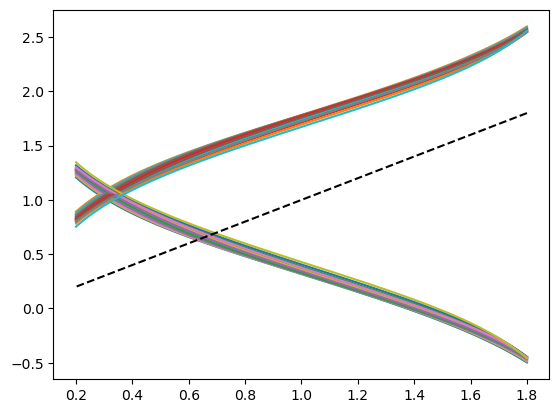

In [51]:
alphas = [.86, .88, .9, .92, .94]
betas = [-4, -3, -2, -1]
for a, b in product(alphas, betas):
  plt.plot(
    2*w_x, 
    (
      4*np.max(
        (
          s_xy(a, b).mean(axis=1)
          -s_x0(a, b).mean(axis=1)[:, None]
        )/y, 
        axis=1)/(
      (np.max(
        (
          s_xy(a, b).mean(axis=1)
          -s_x0(a, b).mean(axis=1)[:, None]
          )/y, 
          axis=1)
      +np.max(
        (
          s_xy(a,b).mean(axis=2)
          -s_y0(a, b).mean(axis=1)[:, None]
          )/x,
          axis=1)
          )
      )
  )-1.5
)
  plt.plot(
    2*w_x, 
    (
      4*np.max(
        (
          s_xy(a, b).mean(axis=2)
          -s_y0(a, b).mean(axis=1)[:, None]
        )/x, 
        axis=1)/(
      (np.max(
        (
          s_xy(a, b).mean(axis=1)
          -s_x0(a, b).mean(axis=1)[:, None]
          )/y, 
          axis=1)
      +np.max(
        (
          s_xy(a,b).mean(axis=2)
          -s_y0(a, b).mean(axis=1)[:, None]
          )/x,
          axis=1)
      )
    )
  )-.4
)
plt.plot((1-w_x)*2, (1-w_x)*2, 'k--')

In [52]:
import plotly.express as px

In [ ]:
s_curve(x_test_n+1.4*y_test_n, 1e-4, .9, 2)/(.2*x_test_n + .3*y_test_n)

/var/folders/zn/5bws03hj4fg23vgtswbr_b1w0000gn/T/ipykernel_76510/855034092.py:4: RuntimeWarning:

divide by zero encountered in divide



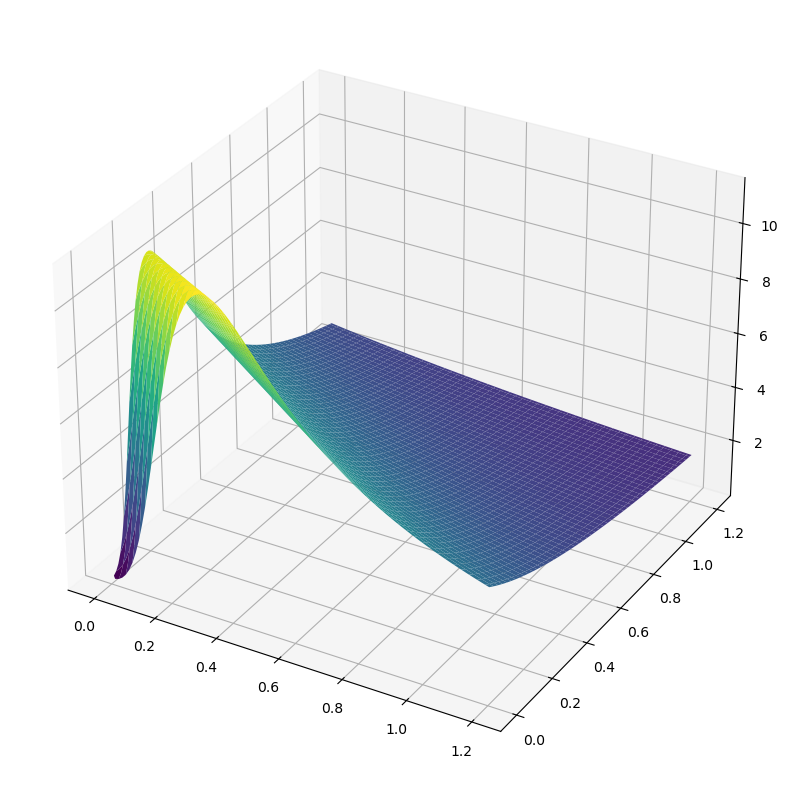

In [107]:
fig, ax = plt.subplots(figsize=(10, 10),  subplot_kw={'projection': '3d'})
x, y = np.linspace(0, 1.2, 100), np.linspace(0, 1.2, 100)
XX, YY = np.meshgrid(x, y)
Z = s_curve(XX + 1.4*YY, 1e-4, .9, 2)/(.2*XX+.3*YY)
ax.plot_surface(XX, YY, Z, cmap='viridis')

In [108]:
import plotly.graph_objects as go

In [111]:
fig = go.Figure(data=[go.Surface(z=Z/8, x=XX, y=YY)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

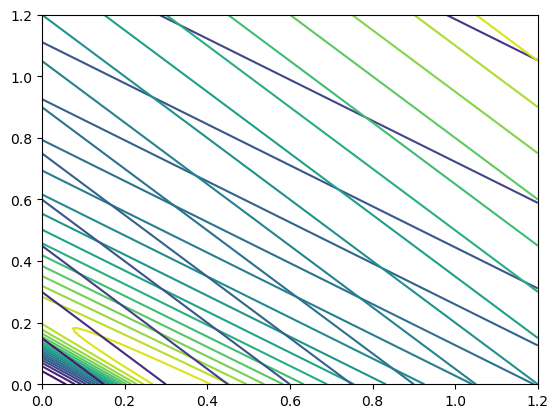

In [110]:
plt.contour(XX, YY, Z, levels=20)
plt.contour(XX, YY, XX+YY, levels=20)

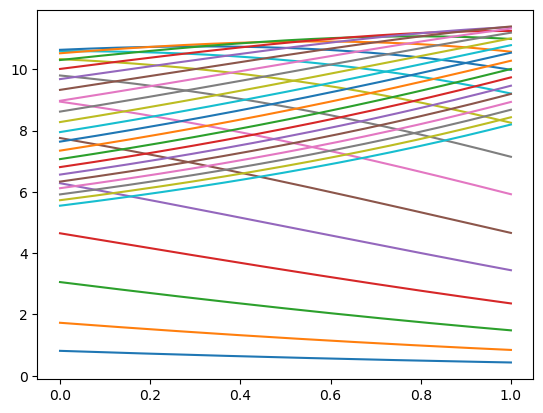

In [106]:
x_test = np.linspace(0, 1, 1000)
for N in np.linspace(0.05, .6, 30):

  x_test_n = N*x_test
  y_test_n = N*(1-x_test)
  plt.plot(x_test, s_curve(x_test_n+1.4*y_test_n, 1e-4, .9, 2)/(.2*x_test_n + .3*y_test_n), label=f"{N:.2f}")
